## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply region mask to ocver the lane region to focus on.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## camera calibration using chessboard images

Perform camera calibration. 

* Use real world points as coordinates of corners and compute image coordinates using opencv functions
* With this information compute distortion coefficients and camera matrix.
* Original and undistorted images are shown below. Observe that, the curved lines in original image are due to distortion and are corrected in image on right.



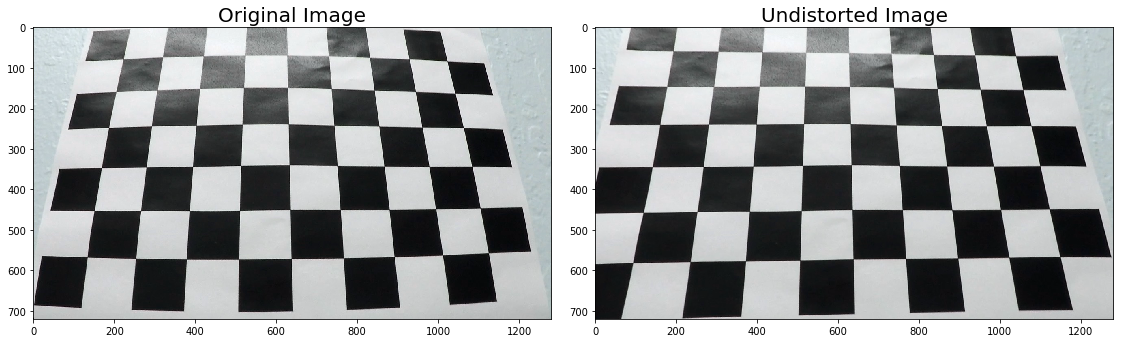

In [1]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print (corners)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
image_raw = cv2.imread('../camera_cal/calibration3.jpg')
image = cv2.undistort(image_raw, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(image_raw)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Sample distortion corrected image

* we pick a sample test image and undistort it using camera matrix and distortion coefficients computed in camera calibration section.

* undistorted image is denoted as **image_undistort**.

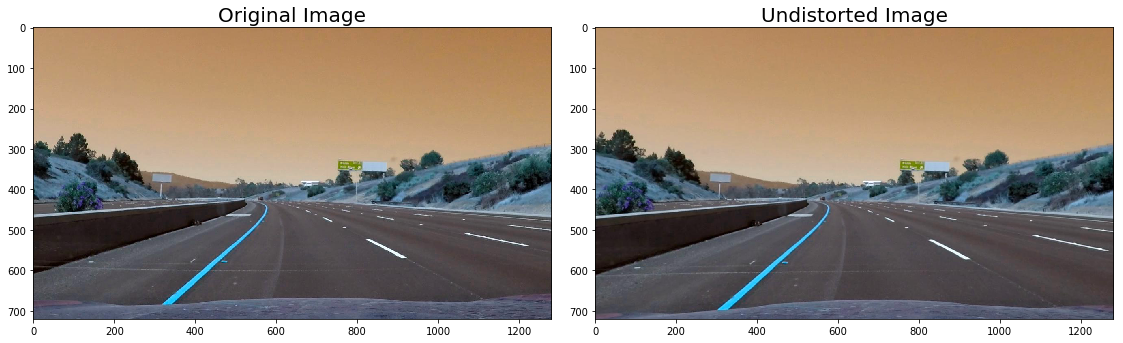

In [2]:
# Undistort a test image using above computed distortion coefficients and camera martix.

#Test image
image_raw = cv2.imread('../test_images/test_imagesframe0.jpg')

#openCV function to undistort camera image.
image_undistort = cv2.undistort(image_raw, mtx, dist, None, mtx)

#Plotting original and undistorted images.
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(image_raw)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image_undistort)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Masking of undistorted image

* In this part of code, I defined a portion of the mimage that could most likely contain all the lane information needed. 

* This masked output is saved as **image** in below code. Further processing of lane detection is performed on this processed image.

Text(0.5,1,'Masked Image')

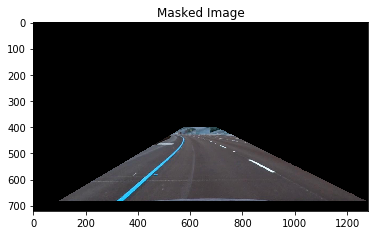

In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



vertices = np.array([[(100,680),(575, 400), (700, 400), (1270,680)]], dtype=np.int32)
image = region_of_interest(image_undistort, vertices)
plt.imshow(image, cmap='gray') 
plt.title("Masked Image")
#print(combined.shape[0])



## Applying colour and gradient threasholds to obtain lane images

* Fundamental goal here is to identify white and yellow lane lines. After careful reading for HLS and LAB colour spaces, I am of the opinion that LAB coulour space is sufficient for this purpose. 
    * We can use Hue for detecting Yellow colour alone. Yellow is a combination of Red(Hue = 0 degree) and Green( Hue = 120 degree). Therefore an angular dimension of 30 degree to 90 degree seems to be a good threshold to start with.Based on conversion rules, for 8 bit images we can represent on 0 to 179 degrees. Hence the thresholds for H in this case to detect yellow are (15, 45) and they correspond to 30 degrees to 90 degrees. However, using B component in LAB coulur spaces yeilds better results. This component is desinged to capture blue and yellow components in an image. 
    * White lines are captured using lightness value component. Note that both components are availble in LAB coulour space and hence we will use that colour space for all our lane detection. 

* It is clear in the below output that B and L components of the image in LAB colour space captures yellow and white lanes in the image.

* **Since I used cv2.imread to read images, they are stored in BGR colour space format.**
    

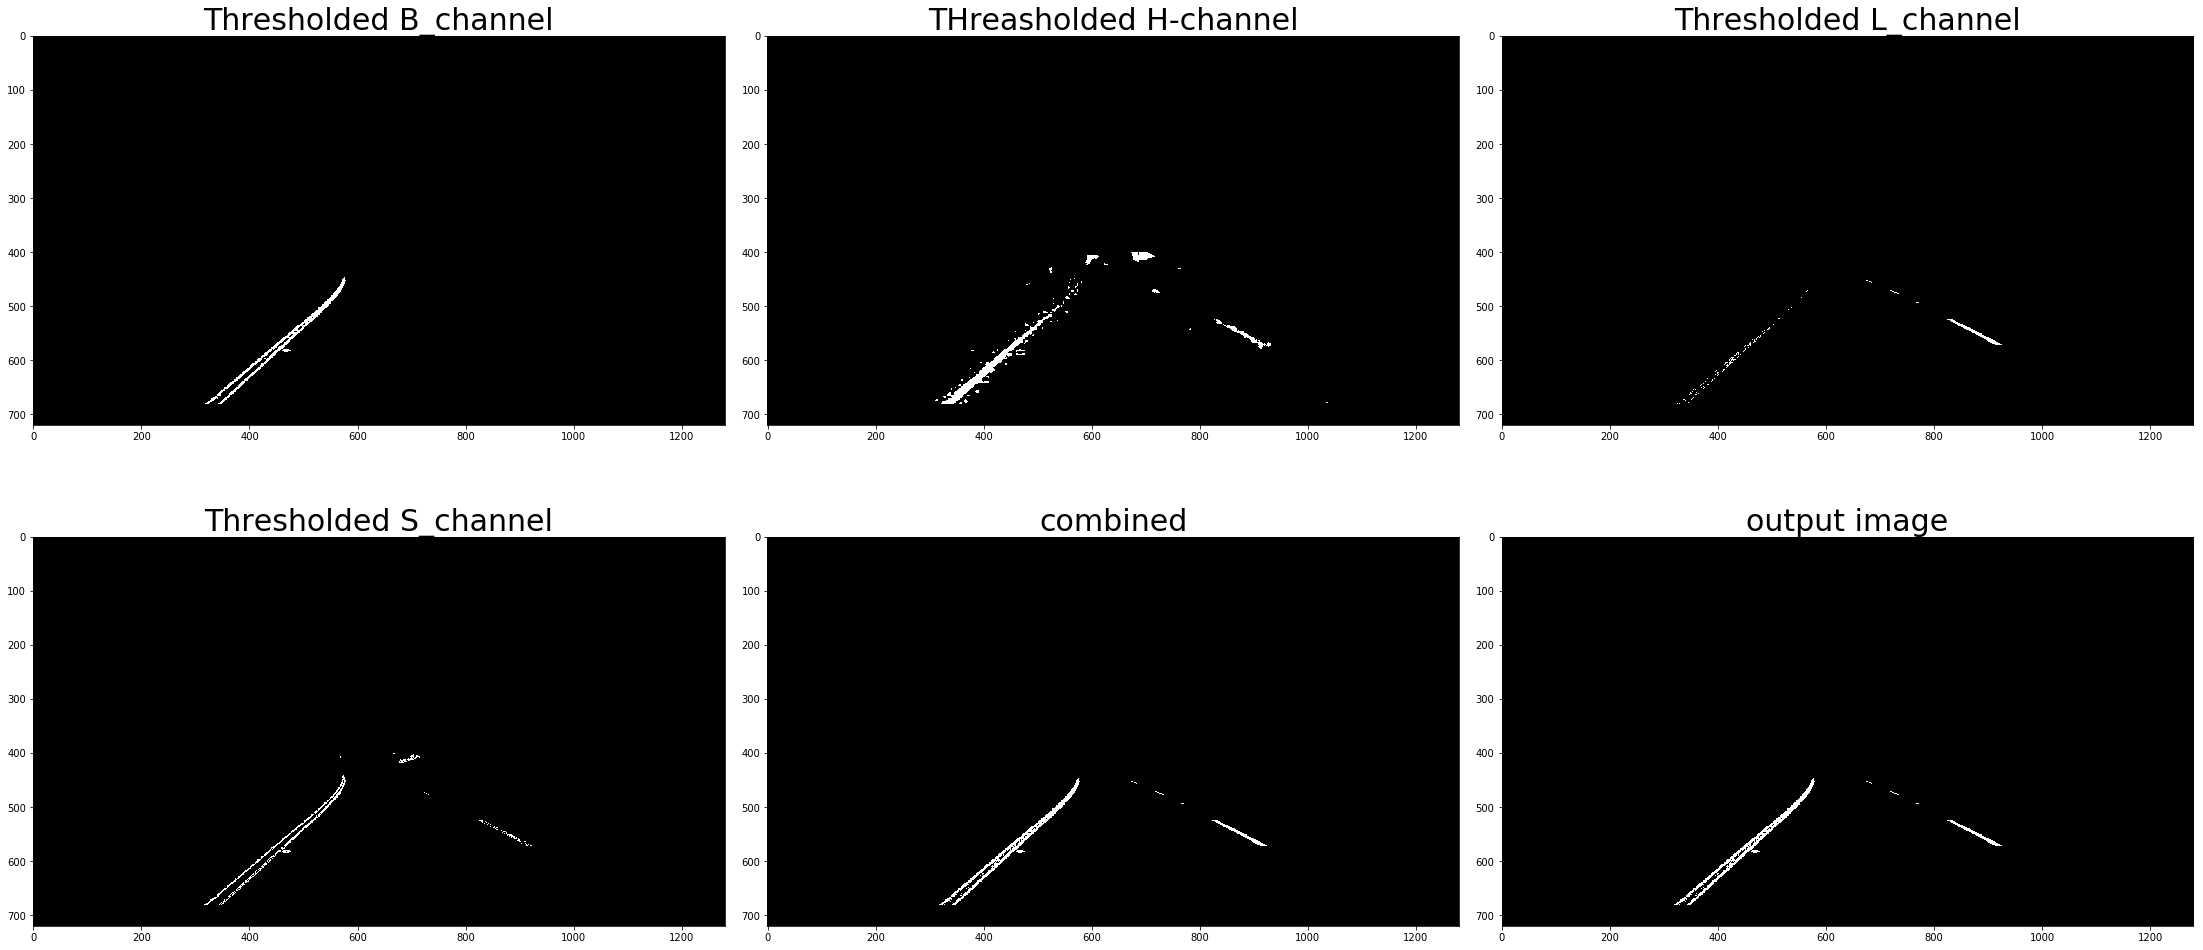

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(100, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(100, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return mag_binary


#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(10, 150))
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 250))


hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
# Threshold color channel
s_thresh_min = 90
s_thresh_max = 200
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

h_channel = hls[:,:,0]
thresh = (20, 45)
h_binary = np.zeros_like(h_channel)
h_binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1

lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

b_channel = lab[:,:,2]
thresh = (155,200)
b_binary = np.zeros_like(b_channel)
b_binary[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1

l_channel = lab[:,:,0]
thresh = (215,255)
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1


#Among all 
combined = np.zeros_like(s_binary)

#Only use L and B channel to detect lanes.
combined[((l_binary == 1) | (b_binary == 1))] = 1 


#Additional masking to remove the edges introduced due to initial masking. 
vertices = np.array([[(120,700),(575, 405), (700, 405), (1220,700)]], dtype=np.int32)
image_new = region_of_interest(combined, vertices)


f,((ax2,ax3,ax4),(ax5,ax6,ax7)) = plt.subplots(2,3, figsize=(30, 15))
f.tight_layout()
#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=50)
ax2.imshow(b_binary, cmap='gray')
ax2.set_title('Thresholded B_channel', fontsize=30)
ax3.imshow(h_binary, cmap='gray')
ax3.set_title('THreasholded H-channel', fontsize=30)
ax4.imshow(l_binary, cmap='gray')
ax4.set_title('Thresholded L_channel', fontsize=30)
ax5.imshow(s_binary, cmap='gray')
ax5.set_title('Thresholded S_channel', fontsize=30)
ax6.imshow(combined, cmap='gray')
ax6.set_title('combined', fontsize=30)
ax7.imshow(image_new, cmap='gray')
ax7.set_title('output image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Masking the region of lane lines

## Applying perspective transformation to compute radius of curvature

* In this section, I performed a careful search for source and destination point to get a good warped image for straight lanes and used it for all images.

Text(0.5,1,'Warped image')

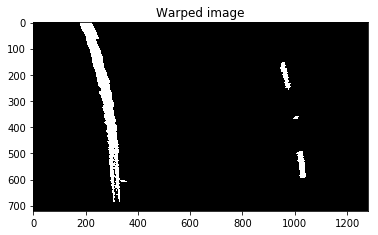

In [5]:


src = np.float32(
        [[580,460],
         [710,460],
         [200,720],
         [1150,720]])
dst = np.float32(
        [[250,0],
         [1000,0],
         [250,700],
         [1000,700]])


# M denotes the transform matrix
M = cv2.getPerspectiveTransform(src, dst)

#Minv denotes inverse transform matirx to convert back to real world corrdinates later
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (image_new.shape[1], image_new.shape[0])
warped = cv2.warpPerspective(image_new, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray') 
plt.title("Warped image")

## Detecting lane pixels and fitting a polynomial for lane markings

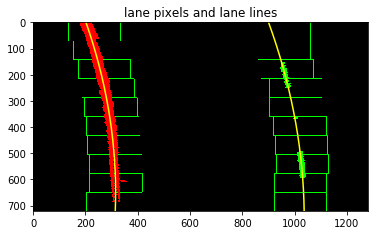

In [15]:
def polyfit(warped, image_new, plot_lanes):
    binary_warped = np.copy(warped)
    #print(binary_warped.shape[0]/2)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #print(right_lane_inds.shape[0])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #print(leftx.shape)
    #print(rightx.shape)
    if (leftx.shape[0] == 0) or (rightx.shape[0] == 0):
        plt.imshow(image_new, cmap='gray')
        plt.title("Warped image")
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    if plot_lanes == True:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #out_img = np.dstack((warped, warped, warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]
        plt.imshow(out_img)
        plt.title("lane pixels and lane lines")
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)      
    
    return left_fit, right_fit

left_fit, right_fit = polyfit(warped,image_new,True)

## Computing Radius of curvatue and deviation from center of lane in real world

* Using the polynomial fit computed in above secition, radius of curvature of both lanes is computed for real world usage.

* Further, assuming that the camera is mounted on the center of the lane in a striaght lane, I computed the position with respect to center of lane by substracting the mid point of left fit  and right fit lanes and the center of image.

5052.21977591 m 5580.98963083 m
0.201137029545


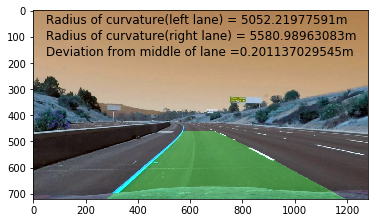

In [14]:

def Curvature_position_computation(image, warped,left_fit, right_fit, Minv):
    '''
    In this function we compute radius of curvature and position of vehicle with respect to center of lane.
    Assuming that camera is mounted in the center and if the vehicle is in center of the lane, 
    it would be exaclty in the middle of picture.
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = image.shape[0]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/260 # meters per pixel in y dimension
    xm_per_pix = 3.7/750 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    #print(pts_left)
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #print(pts_right)
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_raw.shape[1], image_raw.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    
    pix_center_offset = abs(warped.shape[1]/2 - (left_fitx[-1]+right_fitx[-1])/2)*3.7/750
    print(pix_center_offset)
    
    plt.text(50, 50, "Radius of curvature(left lane) = " + str(left_curverad)+'m', fontsize=12)
    plt.text(50, 110, "Radius of curvature(right lane) = " + str(right_curverad)+'m', fontsize=12)
    plt.text(50, 170, "Deviation from middle of lane =" + str(pix_center_offset)+'m', fontsize=12)
    plt.imshow(result)
    
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad, pix_center_offset, result

left_curverad, right_curverad, offset, result = Curvature_position_computation(image_undistort, warped, left_fit, right_fit, Minv)

## Pipeling of lane detection for all test images 

In [19]:
import os
#os.listdir("test_images/")
#image_raw = cv2.imread('../test_images/test5.jpg')
def Combined_image(image):
    
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(10, 150))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 250))

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_thresh_min = 90
    s_thresh_max = 200
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    h_channel = hls[:,:,0]
    thresh = (20, 45)
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1

    l_channel = hls[:,:,1]
    thresh = (215,255)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1


    lab= cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    thresh = (155,255)
    b_binary = np.zeros_like(l_channel)
    b_binary[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1

    #Among all
    combined= np.zeros_like(s_binary)
    #combined[((gradx == 1) & (mag_binary == 1)) | ((s_binary == 1) & (h_binary == 1)) | ((l_binary == 1) | (b_binary == 1))] = 1 
    combined[((l_binary == 1)) | ((b_binary == 1))] = 1 
    #combined[((mag_binary == 1)) | ((s_binary == 1) & (binary == 1))] = 1 
    vertices = np.array([[(120,image_raw.shape[0]-10),(575, 405), (700, 405), (1220,image_raw.shape[0]-10)]], dtype=np.int32)
    image_new = region_of_interest(combined, vertices)
    
    return image_new


def lane_processing(image_raw, mtx, dist, M, Minv):
    image = cv2.undistort(image_raw, mtx, dist, None, mtx)
    

    #vertices = np.array([[(50,image_raw.shape[0]),(575, 450), (750, 450), (1200,image_raw.shape[0])]], dtype=np.int32)
    vertices = np.array([[(100,image_raw.shape[0]),(575, 400), (700, 400), (1270,image_raw.shape[0])]], dtype=np.int32)
    masked_region_image = region_of_interest(image, vertices)
    
    combined = Combined_image(masked_region_image)
    
    img_size = (combined.shape[1], combined.shape[0])
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    left_fit, right_fit = polyfit(warped,combined, False)

    left_curverad, right_curverad, offset, result = Curvature_position_computation(image_raw, warped, left_fit, right_fit, Minv)
    
    cv2.putText(result, 'radius of curvature of left lane {:.2f}m '.format(left_curverad), (100,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'radius of curvature of right lane {:.2f}m '.format(right_curverad), (100,140),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Offset {:.2f}(m)'.format(offset), (120,190),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result




##  Lane detection for all test images 

../test_images/test_imagesframe3.8.jpg
5278.70808842 m 7970.50885323 m
0.0196776226928
../test_images/undistorted_1.jpg
7015.5196374 m 6502.73635187 m
0.162377634138
../test_images/test_imagesframe1.2.jpg
5117.71332624 m 5904.28242357 m
0.148588713775
../test_images/test_imagesframe6.7.jpg
5722.83346737 m 6771.13114774 m
0.132466647707
../test_images/test_imagesframe0.1.jpg
4774.65270319 m 7500.47890199 m
0.218544359923
../test_images/test4.jpg
12374.4139339 m 6245.63694308 m
0.15181981343
../test_images/test1.jpg
4962.03966093 m 9712.07970911 m
0.039043594809
../test_images/test2.jpg
4763.95716164 m 11990.2378005 m
0.26673086523
../test_images/straight_lines2.jpg
21714.2551724 m 4837009.3248 m
0.140723120004
../test_images/test_imagesframe0.jpg
5135.22760251 m 5235.93986433 m
0.200781315069
../test_images/raw1.jpg
7319.68336848 m 7621.00386371 m
0.182176313647
../test_images/test3.jpg
11240.9400214 m 5992.78006526 m
0.0372899702659
../test_images/test_imagesframe0.63.jpg
7385.03259793

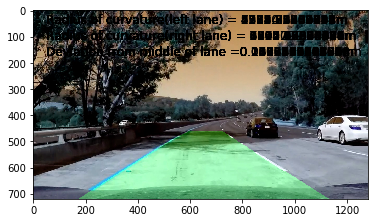

In [16]:
images = os.listdir("../test_images/")

for img in images:
    if ('.ipynb' not in img):
        print ('../test_images/' +  img)
        image = cv2.imread('../test_images/' +  img)
        #gray = cv2.COLOR_RGB2GRAY(image)
        #image = mpimg.imread('test_images/solidYellowCurve2.jpg')
        lane_detect_image = lane_processing(image, mtx, dist, M, Minv)
        #plt.imshow(lane_detect_image)
        mpimg.imsave('../output_images/' + 'processed_' + img, lane_detect_image)
    

## Pipeling of lane detection for test video 

In [17]:
def lane_video(image_raw):
    
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
    #mpimg.imsave('../test_images/' + 'raw1' + '.jpg', image_raw)
    image = cv2.undistort(image_raw, mtx, dist, None, mtx)
    
    #mpimg.imsave('../test_images/' + 'undistorted_1' + '.jpg', image)
    #vertices = np.array([[(50,image_raw.shape[0]),(575, 450), (750, 450), (1200,image_raw.shape[0])]], dtype=np.int32)
    vertices = np.array([[(100,image_raw.shape[0]),(575, 400), (700, 400), (1270,image_raw.shape[0])]], dtype=np.int32)
    masked_region_image = region_of_interest(image, vertices)
    
    combined = Combined_image(masked_region_image)
    
    img_size = (combined.shape[1], combined.shape[0])
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    left_fit, right_fit = polyfit(warped,combined, False)

    left_curverad, right_curverad, offset, result = Curvature_position_computation(image_raw, warped, left_fit, right_fit, Minv)
    
    cv2.putText(result, 'radius of curvature of left lane{:.2f}m '.format(left_curverad), (100,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'radius of curvature of right lane{:.2f}m '.format(right_curverad), (100,140),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Offset {:.2f}(m)'.format(offset), (120,190),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result
    



In [18]:
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.02220032/28549024 bytes (7.8%5365760/28549024 bytes (18.88617984/28549024 bytes (30.212107776/28549024 bytes (42.4%15622144/28549024 bytes (54.7%18817024/28549024 bytes (65.9%21889024/28549024 bytes (76.7%25214976/28549024 bytes (88.3%28385280/28549024 bytes (99.4%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.


## Frame extraction from image based on time 

In [ ]:

def extract_frames(movie, times):
    clip = VideoFileClip(movie)
    for t in times:
        frame_name = "../test_images" + 'frame' + str(t) + '.jpg'
        clip.save_frame(frame_name, t)

movie = "../project_video.mp4"
imgdir = 'frames'
times = [0]

extract_frames(movie, times)

## Lane detection on Video

5195.04777262 m 5497.47799182 m
0.202127042276
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


  0%|          | 1/1261 [00:00<05:27,  3.85it/s]

5195.04777262 m 5497.47799182 m
0.202127042276


  0%|          | 2/1261 [00:00<05:41,  3.69it/s]

4913.05440878 m 6618.71445295 m
0.213653300973


  0%|          | 3/1261 [00:00<05:41,  3.68it/s]

4687.39697421 m 7803.2674089 m
0.218793065831


  0%|          | 4/1261 [00:01<05:38,  3.71it/s]

4561.30383629 m 5332.92800132 m
0.213681967042


  0%|          | 5/1261 [00:01<05:36,  3.74it/s]

4528.67128092 m 5647.27254264 m
0.217318326282


  0%|          | 6/1261 [00:01<05:36,  3.73it/s]

4573.72446693 m 5759.06604371 m
0.224574193575


  1%|          | 7/1261 [00:01<05:37,  3.72it/s]

4626.17034441 m 6040.82450324 m
0.23148212548


  1%|          | 8/1261 [00:02<05:36,  3.72it/s]

4690.66187921 m 8541.30861479 m
0.278551628389


  1%|          | 9/1261 [00:02<05:39,  3.69it/s]

4670.19201004 m 8720.15318928 m
0.270426754722


  1%|          | 10/1261 [00:02<05:42,  3.65it/s]

4891.28404001 m 7742.94480046 m
0.264199049439


  1%|          | 11/1261 [00:02<05:39,  3.68it/s]

5070.17996026 m 8665.2616991 m
0.269650478468


  1%|          | 12/1261 [00:03<05:41,  3.66it/s]

5609.17783633 m 11168.2016032 m
0.276073476181


  1%|          | 13/1261 [00:03<05:40,  3.67it/s]

5839.65832111 m 11045.3549296 m
0.274531519641


  1%|          | 14/1261 [00:03<05:41,  3.65it/s]

6293.77398027 m 12847.7814545 m
0.277127392268


  1%|          | 15/1261 [00:04<05:43,  3.63it/s]

6708.38409878 m 8570.24137332 m
0.264074256967


  1%|▏         | 16/1261 [00:04<05:41,  3.64it/s]

6665.12117956 m 7415.27368895 m
0.247315585285


  1%|▏         | 17/1261 [00:04<05:42,  3.64it/s]

6713.33198043 m 7297.96280233 m
0.23660207065


  1%|▏         | 18/1261 [00:04<05:40,  3.65it/s]

6886.01323464 m 7184.23815416 m
0.23112948867


  2%|▏         | 19/1261 [00:05<05:39,  3.66it/s]

7475.43667091 m 7946.99773188 m
0.231433875463


  2%|▏         | 20/1261 [00:05<05:37,  3.68it/s]

8144.44077059 m 7893.49797583 m
0.228064595655


  2%|▏         | 21/1261 [00:05<05:38,  3.66it/s]

8906.41951829 m 9797.51092117 m
0.23357581407


  2%|▏         | 22/1261 [00:05<05:36,  3.68it/s]

9055.88829013 m 7469.8928995 m
0.20920405678


  2%|▏         | 23/1261 [00:06<05:36,  3.68it/s]

9023.63614774 m 8090.56958723 m
0.201940048869


  2%|▏         | 24/1261 [00:06<05:36,  3.68it/s]

8122.59900911 m 8558.39713683 m
0.199189697698


  2%|▏         | 25/1261 [00:06<05:37,  3.66it/s]

7319.68336848 m 7621.00386371 m
0.182176313647


  2%|▏         | 26/1261 [00:07<05:36,  3.67it/s]

8069.53850944 m 6469.50433144 m
0.169625252748


  2%|▏         | 27/1261 [00:07<05:36,  3.67it/s]

7195.25765972 m 6484.23028007 m
0.164664762171


  2%|▏         | 28/1261 [00:07<05:35,  3.67it/s]

7223.41222714 m 6816.26788013 m
0.164280483643


  2%|▏         | 29/1261 [00:07<05:35,  3.67it/s]

6499.8099029 m 5420.37796378 m
0.154282926266


  2%|▏         | 30/1261 [00:08<05:36,  3.66it/s]

5479.93195154 m 5232.82207702 m
0.143034160039


  2%|▏         | 31/1261 [00:08<05:40,  3.62it/s]

5089.05011814 m 5810.76121528 m
0.148173610728


  3%|▎         | 32/1261 [00:08<05:38,  3.63it/s]

4688.30617942 m 5288.53833218 m
0.144061096938


  3%|▎         | 33/1261 [00:09<05:35,  3.66it/s]

4711.60693414 m 5767.52735583 m
0.152204801251


  3%|▎         | 34/1261 [00:09<05:34,  3.67it/s]

4393.18993819 m 6831.26135939 m
0.171088894182


  3%|▎         | 35/1261 [00:09<06:31,  3.13it/s]

4177.65027085 m 6922.63326774 m
0.173446853244


  3%|▎         | 36/1261 [00:09<06:10,  3.30it/s]

4081.71732689 m 6871.92137231 m
0.17820888622


  3%|▎         | 37/1261 [00:10<06:00,  3.40it/s]

3947.98055443 m 6475.77877269 m
0.166964764859


  3%|▎         | 38/1261 [00:10<05:53,  3.46it/s]

3756.24576621 m 5731.22710418 m
0.159865262269


  3%|▎         | 39/1261 [00:10<05:48,  3.51it/s]

3534.11578009 m 5961.07771082 m
0.157510270914


  3%|▎         | 40/1261 [00:11<05:42,  3.57it/s]

3551.74455668 m 6680.63044269 m
0.162675366415


  3%|▎         | 41/1261 [00:11<05:40,  3.59it/s]

3675.06036329 m 5291.21312695 m
0.161166043909


  3%|▎         | 42/1261 [00:11<05:38,  3.60it/s]

3655.46529032 m 5109.29475859 m
0.166254692162


  3%|▎         | 43/1261 [00:12<07:22,  2.75it/s]

3697.43729186 m 5203.90257373 m
0.172792589766


  3%|▎         | 44/1261 [00:12<07:15,  2.79it/s]

3819.38239429 m 4925.0796387 m
0.17518007449


  4%|▎         | 45/1261 [00:12<07:48,  2.60it/s]

3935.26936324 m 4957.71945233 m
0.184788129572


  4%|▎         | 46/1261 [00:13<07:43,  2.62it/s]

4053.90027021 m 6819.12227483 m
0.216000145891


  4%|▎         | 47/1261 [00:13<07:26,  2.72it/s]

4238.64984551 m 6129.50313252 m
0.202711302391


  4%|▍         | 48/1261 [00:14<07:26,  2.72it/s]

4293.01887181 m 5955.94066658 m
0.204489088538


  4%|▍         | 49/1261 [00:14<07:11,  2.81it/s]

4720.42889777 m 6202.23544289 m
0.211508204053


  4%|▍         | 50/1261 [00:14<07:22,  2.74it/s]

5086.02214232 m 6354.69237066 m
0.216446926347


  4%|▍         | 51/1261 [00:15<07:14,  2.78it/s]

5547.5342686 m 5098.64217067 m
0.203525534233


  4%|▍         | 52/1261 [00:15<07:27,  2.70it/s]

5913.22714984 m 5013.4756189 m
0.206074673525


  4%|▍         | 53/1261 [00:15<07:23,  2.72it/s]

6409.7386086 m 5705.02970661 m
0.209128670628


  4%|▍         | 54/1261 [00:16<07:24,  2.71it/s]

6976.34211568 m 5201.09775597 m
0.205780584278


  4%|▍         | 55/1261 [00:16<07:15,  2.77it/s]

7392.90285336 m 4989.28075415 m
0.204051638785


  4%|▍         | 56/1261 [00:16<07:26,  2.70it/s]

8417.4281407 m 5337.58517052 m
0.204456547305


  5%|▍         | 57/1261 [00:17<07:16,  2.76it/s]

8420.75317502 m 5168.16525345 m
0.203661779508


  5%|▍         | 58/1261 [00:17<07:25,  2.70it/s]

8731.54848511 m 5545.03172575 m
0.200684201808


  5%|▍         | 59/1261 [00:18<07:19,  2.73it/s]

7628.36281608 m 6938.99675376 m
0.218078512375


  5%|▍         | 60/1261 [00:18<07:27,  2.69it/s]

6775.31513927 m 6990.47756885 m
0.197037200595


  5%|▍         | 61/1261 [00:18<07:18,  2.74it/s]

6256.01137157 m 8151.72294882 m
0.185799999512


  5%|▍         | 62/1261 [00:19<07:25,  2.69it/s]

6283.58392781 m 7130.04520153 m
0.173080618258


  5%|▍         | 63/1261 [00:19<07:18,  2.73it/s]

6352.53313379 m 6741.19020078 m
0.154970911639


  5%|▌         | 64/1261 [00:19<07:31,  2.65it/s]

5964.87175835 m 7340.77865465 m
0.146824535514


  5%|▌         | 65/1261 [00:20<07:23,  2.70it/s]

5601.59770126 m 7397.34835487 m
0.132704908679


  5%|▌         | 66/1261 [00:20<07:30,  2.65it/s]

5455.00864856 m 7021.89253738 m
0.123114581343


  5%|▌         | 67/1261 [00:21<07:17,  2.73it/s]

5908.7838194 m 7098.7512114 m
0.115072465151


  5%|▌         | 68/1261 [00:21<07:27,  2.67it/s]

5713.76793885 m 7291.49375544 m
0.103085167571


  5%|▌         | 69/1261 [00:21<07:14,  2.74it/s]

5659.80015278 m 7061.52587655 m
0.0988495507135


  6%|▌         | 70/1261 [00:22<07:18,  2.71it/s]

5528.14017906 m 7640.09447847 m
0.093471705595


  6%|▌         | 71/1261 [00:22<07:10,  2.76it/s]

5720.16894104 m 11570.3426356 m
0.121007451792


  6%|▌         | 72/1261 [00:22<07:23,  2.68it/s]

6340.61054088 m 11708.9068332 m
0.114518924915


  6%|▌         | 73/1261 [00:23<07:13,  2.74it/s]

6945.44922046 m 12039.5983485 m
0.112706408575


  6%|▌         | 74/1261 [00:23<07:21,  2.69it/s]

7490.51072923 m 10510.5390413 m
0.100363578058


  6%|▌         | 75/1261 [00:23<07:08,  2.77it/s]

9228.10173762 m 11459.1293166 m
0.0982760364115


  6%|▌         | 76/1261 [00:24<07:15,  2.72it/s]

9661.11243658 m 7193.07645274 m
0.0784779524288


  6%|▌         | 77/1261 [00:24<07:08,  2.76it/s]

10950.2701282 m 7070.32756566 m
0.0744443315642


  6%|▌         | 78/1261 [00:25<07:21,  2.68it/s]

14300.8543415 m 7157.48364026 m
0.0775344227427


  6%|▋         | 79/1261 [00:25<07:10,  2.74it/s]

14912.0618843 m 7174.19607198 m
0.0685829744999


  6%|▋         | 80/1261 [00:25<07:20,  2.68it/s]

15227.3785686 m 4911.64114678 m
0.0509368147264


  6%|▋         | 81/1261 [00:26<07:09,  2.75it/s]

15117.1852319 m 5241.09654138 m
0.0431034884145


  7%|▋         | 82/1261 [00:26<07:12,  2.73it/s]

14078.1961635 m 5529.27483447 m
0.0342466126235


  7%|▋         | 83/1261 [00:26<06:59,  2.81it/s]

12194.1098802 m 5693.12734697 m
0.0319670178359


  7%|▋         | 84/1261 [00:27<07:04,  2.77it/s]

15131.3503427 m 10511.5045314 m
0.0830669672434


  7%|▋         | 85/1261 [00:27<06:55,  2.83it/s]

11945.1896891 m 8068.86442122 m
0.0548601458327


  7%|▋         | 86/1261 [00:27<07:01,  2.79it/s]

9719.00251844 m 7606.90433297 m
0.0381738876997


  7%|▋         | 87/1261 [00:28<07:06,  2.76it/s]

7357.22021209 m 8323.65253883 m
0.031399177673


  7%|▋         | 88/1261 [00:28<07:08,  2.73it/s]

6329.39359569 m 5632.31450248 m
0.00284714591714


  7%|▋         | 89/1261 [00:29<07:03,  2.77it/s]

5938.10873965 m 7647.88755121 m
0.00930886698922


  7%|▋         | 90/1261 [00:29<07:12,  2.71it/s]

5504.40260484 m 5650.59938983 m
0.00153418960778


  7%|▋         | 91/1261 [00:29<06:59,  2.79it/s]

5286.13742018 m 6104.54680316 m
0.000790861440289


  7%|▋         | 92/1261 [00:30<07:07,  2.74it/s]

5459.10581392 m 6422.04415414 m
0.00658358424181


  7%|▋         | 93/1261 [00:30<06:59,  2.78it/s]

5280.87657925 m 6503.13615405 m
0.00422552043914


  7%|▋         | 94/1261 [00:30<07:05,  2.74it/s]

5393.96414789 m 6299.63099651 m
0.00866811390268


  8%|▊         | 95/1261 [00:31<07:07,  2.73it/s]

5347.23964625 m 6897.45542109 m
0.00558844039209


  8%|▊         | 96/1261 [00:31<06:59,  2.78it/s]

5208.31779197 m 8008.95411058 m
0.0198161077066


  8%|▊         | 97/1261 [00:31<07:04,  2.74it/s]

5498.82141924 m 6918.12472921 m
0.0113999521083


  8%|▊         | 98/1261 [00:32<07:13,  2.68it/s]

5422.6889063 m 7703.15183 m
0.0170301872843


  8%|▊         | 99/1261 [00:32<07:07,  2.72it/s]

5463.4555332 m 7827.99542169 m
0.0208416167126


  8%|▊         | 100/1261 [00:33<07:11,  2.69it/s]

5742.91437881 m 7561.89480079 m
0.0206710473499


  8%|▊         | 101/1261 [00:33<07:02,  2.74it/s]

5810.73893313 m 4201.88677796 m
0.0112676920821


  8%|▊         | 102/1261 [00:33<07:18,  2.64it/s]

5785.12492266 m 4924.83528067 m
0.00357684720102


  8%|▊         | 103/1261 [00:34<08:45,  2.20it/s]

5617.39159625 m 5091.92580907 m
0.0113626135161


  8%|▊         | 104/1261 [00:35<09:21,  2.06it/s]

5781.58402623 m 4907.56791465 m
0.0197854311252


  8%|▊         | 105/1261 [00:35<08:43,  2.21it/s]

6150.66996642 m 5079.78131597 m
0.0313112268036


  8%|▊         | 106/1261 [00:35<08:31,  2.26it/s]

6091.81234656 m 5610.05129886 m
0.0393496191885


  8%|▊         | 107/1261 [00:36<07:59,  2.41it/s]

5982.87311121 m 5918.26141297 m
0.0481071960455


  9%|▊         | 108/1261 [00:36<07:49,  2.46it/s]

5368.83275342 m 5995.11844769 m
0.0574404223875


  9%|▊         | 109/1261 [00:36<07:25,  2.59it/s]

5197.42290952 m 7749.6873625 m
0.0845052576118


  9%|▊         | 110/1261 [00:37<07:23,  2.60it/s]

5295.20919979 m 7090.18231579 m
0.0786492409837


  9%|▉         | 111/1261 [00:37<07:05,  2.70it/s]

5110.45559338 m 8278.71640546 m
0.0914215775098


  9%|▉         | 112/1261 [00:38<07:13,  2.65it/s]

5391.34555505 m 9787.84041718 m
0.101071525503


  9%|▉         | 113/1261 [00:38<07:04,  2.71it/s]

5111.32221779 m 9535.44076272 m
0.103054503653


  9%|▉         | 114/1261 [00:38<07:10,  2.67it/s]

4888.86303111 m 7551.59717311 m
0.0918937543403


  9%|▉         | 115/1261 [00:39<07:03,  2.71it/s]

4542.15682654 m 8730.26989008 m
0.0988626087055


  9%|▉         | 116/1261 [00:39<08:17,  2.30it/s]

4597.57401927 m 4354.74745803 m
0.0735003108344


  9%|▉         | 117/1261 [00:40<08:24,  2.27it/s]

4605.9573178 m 4924.46723763 m
0.0847008896807


  9%|▉         | 118/1261 [00:40<08:08,  2.34it/s]

4497.28530064 m 4294.21541643 m
0.0844907276022


  9%|▉         | 119/1261 [00:40<07:41,  2.48it/s]

4483.10692392 m 4219.765824 m
0.0918757541033


 10%|▉         | 120/1261 [00:41<08:06,  2.34it/s]

4216.23829412 m 4151.39869415 m
0.0981623214297


 10%|▉         | 121/1261 [00:41<08:32,  2.23it/s]

4163.19565808 m 4255.44904295 m
0.104524610648


 10%|▉         | 122/1261 [00:42<07:51,  2.42it/s]

4131.90877536 m 4356.41108608 m
0.119852469263


 10%|▉         | 123/1261 [00:42<07:33,  2.51it/s]

4064.9632789 m 4477.04227182 m
0.127278767672


 10%|▉         | 124/1261 [00:42<07:02,  2.69it/s]

4127.39470436 m 4538.60365552 m
0.135319286891


 10%|▉         | 125/1261 [00:43<06:55,  2.74it/s]

4097.03297412 m 4725.89491724 m
0.144096590656


 10%|▉         | 126/1261 [00:43<06:33,  2.88it/s]

4424.08621793 m 4309.6877804 m
0.140453600713


 10%|█         | 127/1261 [00:43<06:32,  2.89it/s]

4430.02101096 m 4261.62758501 m
0.149966642344


 10%|█         | 128/1261 [00:44<06:16,  3.01it/s]

4665.83518476 m 4502.74740284 m
0.159835500561


 10%|█         | 129/1261 [00:44<06:21,  2.97it/s]

4559.3470686 m 5017.2309708 m
0.170640737148


 10%|█         | 130/1261 [00:44<06:11,  3.05it/s]

4687.01013342 m 4534.90705816 m
0.164264435551


 10%|█         | 131/1261 [00:45<06:16,  3.00it/s]

4803.6230731 m 4476.50605765 m
0.17087468204


 10%|█         | 132/1261 [00:45<06:04,  3.09it/s]

4652.80556406 m 4804.80840426 m
0.176565892462


 11%|█         | 133/1261 [00:45<06:15,  3.00it/s]

4930.86252984 m 5048.21968994 m
0.187802312699


 11%|█         | 134/1261 [00:46<06:13,  3.02it/s]

5127.47595691 m 5964.9975133 m
0.222155074831


 11%|█         | 135/1261 [00:46<06:17,  2.98it/s]

5173.31835244 m 5586.16764644 m
0.214754180476


 11%|█         | 136/1261 [00:46<06:02,  3.10it/s]

5520.18913133 m 6543.11272001 m
0.229618698753


 11%|█         | 137/1261 [00:47<06:09,  3.04it/s]

5728.77705161 m 6124.37050937 m
0.222344260377


 11%|█         | 138/1261 [00:47<06:00,  3.11it/s]

5910.06200104 m 6525.38959419 m
0.223719925307


 11%|█         | 139/1261 [00:47<06:12,  3.01it/s]

6120.15276905 m 5148.37976044 m
0.205152942841


 11%|█         | 140/1261 [00:48<06:05,  3.07it/s]

6554.28111134 m 6760.74817826 m
0.21669138679


 11%|█         | 141/1261 [00:48<06:16,  2.98it/s]

6538.3056705 m 7249.4273698 m
0.216439050309


 11%|█▏        | 142/1261 [00:48<06:12,  3.01it/s]

6551.0888109 m 7241.79040972 m
0.211137930063


 11%|█▏        | 143/1261 [00:49<06:23,  2.91it/s]

5975.46116032 m 6376.48054384 m
0.200197036517


 11%|█▏        | 144/1261 [00:49<06:15,  2.97it/s]

6004.71198942 m 7296.82571849 m
0.193257679684


 11%|█▏        | 145/1261 [00:49<06:23,  2.91it/s]

6291.25674385 m 7263.88510477 m
0.194464108342


 12%|█▏        | 146/1261 [00:50<06:16,  2.96it/s]

6343.65838915 m 7022.46109234 m
0.196974361115


 12%|█▏        | 147/1261 [00:50<06:26,  2.88it/s]

6499.68953888 m 12754.7997152 m
0.235213092183


 12%|█▏        | 148/1261 [00:50<06:20,  2.92it/s]

6130.65256955 m 9763.83749047 m
0.221135453096


 12%|█▏        | 149/1261 [00:51<06:39,  2.78it/s]

6388.00772992 m 12796.1121066 m
0.231277283173


 12%|█▏        | 150/1261 [00:51<06:34,  2.82it/s]

6718.23598034 m 11043.7057494 m
0.21989856578


 12%|█▏        | 151/1261 [00:52<06:42,  2.76it/s]

7223.22852465 m 8210.28318283 m
0.201206286104


 12%|█▏        | 152/1261 [00:52<06:38,  2.78it/s]

7147.33683554 m 9032.06094404 m
0.194618888618


 12%|█▏        | 153/1261 [00:52<06:47,  2.72it/s]

7056.78939481 m 5653.40801122 m
0.173502931735


 12%|█▏        | 154/1261 [00:53<06:35,  2.80it/s]

7535.82894291 m 5635.45016111 m
0.174565235845


 12%|█▏        | 155/1261 [00:53<06:39,  2.77it/s]

7507.2611958 m 5941.73191344 m
0.173992519394


 12%|█▏        | 156/1261 [00:53<06:45,  2.72it/s]

6801.6528145 m 5514.39121397 m
0.162764543782


 12%|█▏        | 157/1261 [00:54<06:36,  2.79it/s]

6934.85197116 m 5470.4495894 m
0.159501174305


 13%|█▎        | 158/1261 [00:54<06:48,  2.70it/s]

5719.58274197 m 5222.616755 m
0.141769709332


 13%|█▎        | 159/1261 [00:54<06:36,  2.78it/s]

5967.02936521 m 7220.003542 m
0.173158495493


 13%|█▎        | 160/1261 [00:55<06:42,  2.73it/s]

5511.28051517 m 7469.58602429 m
0.1651899567


 13%|█▎        | 161/1261 [00:55<06:33,  2.79it/s]

5493.53522516 m 7774.18513112 m
0.163408973741


 13%|█▎        | 162/1261 [00:56<07:22,  2.48it/s]

5506.3125686 m 6928.39004804 m
0.150675909055


 13%|█▎        | 163/1261 [00:56<07:32,  2.43it/s]

5602.43711491 m 7668.5396625 m
0.153944600435


 13%|█▎        | 164/1261 [00:56<07:17,  2.51it/s]

5430.80624007 m 12516.4480629 m
0.16555161312


 13%|█▎        | 165/1261 [00:57<07:31,  2.43it/s]

5168.05149901 m 10785.2279467 m
0.151392145943


 13%|█▎        | 166/1261 [00:57<07:04,  2.58it/s]

5614.22069973 m 13028.3345017 m
0.150648501479


 13%|█▎        | 167/1261 [00:58<07:08,  2.55it/s]

5147.82173176 m 6644.40968024 m
0.129273249968


 13%|█▎        | 168/1261 [00:58<06:53,  2.64it/s]

5447.20807474 m 7057.20409295 m
0.131099204813


 13%|█▎        | 169/1261 [00:58<06:56,  2.62it/s]

5918.00840291 m 6529.11740206 m
0.130539860419


 13%|█▎        | 170/1261 [00:59<06:46,  2.68it/s]

6673.91049351 m 7036.68725814 m
0.126782183277


 14%|█▎        | 171/1261 [00:59<06:51,  2.65it/s]

7297.30334797 m 6054.56555414 m
0.11128599218


 14%|█▎        | 172/1261 [00:59<06:36,  2.75it/s]

7490.46067055 m 5948.62160114 m
0.101131993512


 14%|█▎        | 173/1261 [01:00<06:39,  2.72it/s]

7275.7389628 m 5100.81781439 m
0.0840714146813


 14%|█▍        | 174/1261 [01:00<06:26,  2.81it/s]

6778.04143611 m 5398.53018719 m
0.0845199287177


 14%|█▍        | 175/1261 [01:00<06:30,  2.78it/s]

6563.46860253 m 5298.61511382 m
0.0801584301834


 14%|█▍        | 176/1261 [01:01<06:20,  2.85it/s]

6083.99565877 m 3645.661912 m
0.0443433903379


 14%|█▍        | 177/1261 [01:01<06:27,  2.80it/s]

6819.27923847 m 3848.57082313 m
0.0506749443219


 14%|█▍        | 178/1261 [01:02<06:18,  2.86it/s]

6865.37842325 m 4310.25955536 m
0.0636329683481


 14%|█▍        | 179/1261 [01:02<06:28,  2.79it/s]

6592.89129049 m 4073.39667872 m
0.0664959495933


 14%|█▍        | 180/1261 [01:02<06:21,  2.83it/s]

6082.96479598 m 3742.36865761 m
0.0633751699274


 14%|█▍        | 181/1261 [01:03<06:27,  2.79it/s]

5259.63405633 m 3232.38786086 m
0.0577955838478


 14%|█▍        | 182/1261 [01:03<06:19,  2.84it/s]

5183.03733023 m 3268.61748134 m
0.0577066813526


 15%|█▍        | 183/1261 [01:03<06:33,  2.74it/s]

4706.74344544 m 3175.23329897 m
0.0574067234752


 15%|█▍        | 184/1261 [01:04<06:27,  2.78it/s]

4303.90793509 m 3495.4274017 m
0.0750179046014


 15%|█▍        | 185/1261 [01:04<06:37,  2.71it/s]

3928.68776484 m 3650.90413864 m
0.0780150949665


 15%|█▍        | 186/1261 [01:04<06:29,  2.76it/s]

3406.33012955 m 3414.49811296 m
0.0704984844121


 15%|█▍        | 187/1261 [01:05<06:35,  2.71it/s]

3417.64907097 m 3929.45691526 m
0.0852327999512


 15%|█▍        | 188/1261 [01:05<06:40,  2.68it/s]

3275.11971898 m 3444.7054275 m
0.078951382217


 15%|█▍        | 189/1261 [01:06<06:28,  2.76it/s]

3369.17132079 m 3240.03427525 m
0.0798263620644


 15%|█▌        | 190/1261 [01:06<06:30,  2.74it/s]

3471.60489251 m 3984.13666924 m
0.103644673139


 15%|█▌        | 191/1261 [01:06<06:22,  2.80it/s]

3365.91770343 m 4037.6328248 m
0.108179596368


 15%|█▌        | 192/1261 [01:07<06:30,  2.74it/s]

3632.7587927 m 3384.58695863 m
0.113732351989


 15%|█▌        | 193/1261 [01:07<06:20,  2.80it/s]

3727.88172025 m 4609.84181947 m
0.135091920787


 15%|█▌        | 194/1261 [01:07<06:24,  2.78it/s]

4091.02009355 m 4685.79294266 m
0.143721831933


 15%|█▌        | 195/1261 [01:08<06:55,  2.56it/s]

4194.84552108 m 4791.80784653 m
0.147716304674


 16%|█▌        | 196/1261 [01:08<06:36,  2.68it/s]

4688.98312021 m 5556.60926344 m
0.158703034764


 16%|█▌        | 197/1261 [01:09<06:38,  2.67it/s]

5055.15587586 m 6280.95535062 m
0.159563384304


 16%|█▌        | 198/1261 [01:09<06:24,  2.76it/s]

5591.17511849 m 6757.34171391 m
0.157089150108


 16%|█▌        | 199/1261 [01:09<06:30,  2.72it/s]

5985.60930319 m 6907.82014872 m
0.149744261822


 16%|█▌        | 200/1261 [01:10<06:17,  2.81it/s]

6184.52702925 m 7422.86104251 m
0.151602127771


 16%|█▌        | 201/1261 [01:10<06:22,  2.77it/s]

6805.78232736 m 6483.77881378 m
0.137252089728


 16%|█▌        | 202/1261 [01:10<06:11,  2.85it/s]

6621.52063946 m 6335.30548495 m
0.130969716918


 16%|█▌        | 203/1261 [01:11<06:17,  2.80it/s]

6592.27070748 m 6291.07355387 m
0.122411930056


 16%|█▌        | 204/1261 [01:11<06:05,  2.89it/s]

6090.00141313 m 6671.80960948 m
0.114345305594


 16%|█▋        | 205/1261 [01:11<06:12,  2.84it/s]

5536.64480648 m 5353.17652205 m
0.103025697766


 16%|█▋        | 206/1261 [01:12<06:04,  2.90it/s]

5401.96000449 m 5305.85440424 m
0.103465813049


 16%|█▋        | 207/1261 [01:12<06:11,  2.84it/s]

4882.57600436 m 4626.34455043 m
0.100402555724


 16%|█▋        | 208/1261 [01:13<07:12,  2.43it/s]

4672.68176411 m 6751.19586094 m
0.133713844108


 17%|█▋        | 209/1261 [01:13<08:00,  2.19it/s]

4859.09674955 m 5381.17273488 m
0.123782545956


 17%|█▋        | 210/1261 [01:13<07:20,  2.38it/s]

4874.66274864 m 5502.19055594 m
0.122177581547


 17%|█▋        | 211/1261 [01:14<07:06,  2.46it/s]

4942.62016061 m 5441.46752722 m
0.114137068681


 17%|█▋        | 212/1261 [01:14<06:42,  2.60it/s]

4775.84537503 m 6085.51245674 m
0.118001493929


 17%|█▋        | 213/1261 [01:15<06:36,  2.65it/s]

4644.23793581 m 4440.10819952 m
0.0893745731892


 17%|█▋        | 214/1261 [01:15<06:18,  2.76it/s]

4509.10459488 m 5249.39969059 m
0.0985517853953


 17%|█▋        | 215/1261 [01:15<06:22,  2.73it/s]

4564.77190073 m 4907.56352154 m
0.0872678483393


 17%|█▋        | 216/1261 [01:16<06:09,  2.83it/s]

4455.020876 m 4799.46235117 m
0.0792258695889


 17%|█▋        | 217/1261 [01:16<06:13,  2.79it/s]

4407.68388186 m 5891.11071716 m
0.0774314568038


 17%|█▋        | 218/1261 [01:16<06:05,  2.86it/s]

4722.2210437 m 6271.88082474 m
0.0747667852757


 17%|█▋        | 219/1261 [01:17<06:10,  2.81it/s]

4504.64964111 m 5906.42458283 m
0.0702264761277


 17%|█▋        | 220/1261 [01:17<06:00,  2.89it/s]

4877.37489365 m 6509.71654836 m
0.0732931560786


 18%|█▊        | 221/1261 [01:17<06:06,  2.84it/s]

5210.92459222 m 10728.5692635 m
0.115511844503


 18%|█▊        | 222/1261 [01:18<05:56,  2.92it/s]

5428.9088793 m 9933.15274873 m
0.108146291458


 18%|█▊        | 223/1261 [01:18<06:09,  2.81it/s]

5761.95565828 m 10284.8979292 m
0.105886358692


 18%|█▊        | 224/1261 [01:18<06:03,  2.86it/s]

5761.76435762 m 10740.2335987 m
0.100909392866


 18%|█▊        | 225/1261 [01:19<06:12,  2.78it/s]

5899.11336526 m 16294.5994496 m
0.102572317796


 18%|█▊        | 226/1261 [01:19<06:00,  2.87it/s]

5846.09221957 m 18587.1030594 m
0.0897857054698


 18%|█▊        | 227/1261 [01:19<06:06,  2.82it/s]

6306.8085458 m 15774.5368263 m
0.0739855298023


 18%|█▊        | 228/1261 [01:20<05:57,  2.89it/s]

6790.8109429 m 8236.63206566 m
0.0536264837482


 18%|█▊        | 229/1261 [01:20<06:04,  2.83it/s]

6820.25395824 m 6328.27190671 m
0.0353581036339


 18%|█▊        | 230/1261 [01:20<05:57,  2.88it/s]

7292.12343174 m 6575.71853355 m
0.0256907945194


 18%|█▊        | 231/1261 [01:21<06:04,  2.82it/s]

7369.21838842 m 6151.36183656 m
0.0170335316778


 18%|█▊        | 232/1261 [01:21<05:56,  2.89it/s]

7850.73522793 m 6470.71854115 m
0.00628783402288


 18%|█▊        | 233/1261 [01:22<06:07,  2.80it/s]

7570.33336732 m 6856.0187962 m
0.00698113090372


 19%|█▊        | 234/1261 [01:22<05:58,  2.87it/s]

7660.63541314 m 6690.88211617 m
0.00276571411182


 19%|█▊        | 235/1261 [01:22<06:04,  2.81it/s]

7007.35352733 m 7601.98446499 m
0.00690313131419


 19%|█▊        | 236/1261 [01:23<05:56,  2.88it/s]

6602.25107193 m 6489.95395001 m
0.021269046588


 19%|█▉        | 237/1261 [01:23<06:00,  2.84it/s]

6607.58186591 m 4566.96811756 m
0.0537042997805


 19%|█▉        | 238/1261 [01:23<05:55,  2.88it/s]

6360.41922113 m 5604.12894591 m
0.0435687160113


 19%|█▉        | 239/1261 [01:24<06:05,  2.80it/s]

6400.04584789 m 4930.90511354 m
0.056658256586


 19%|█▉        | 240/1261 [01:24<05:59,  2.84it/s]

6396.46763175 m 5940.85036485 m
0.052318939289


 19%|█▉        | 241/1261 [01:24<06:05,  2.79it/s]

5937.02611367 m 5143.23823817 m
0.066850231454


 19%|█▉        | 242/1261 [01:25<05:55,  2.87it/s]

5995.74214863 m 4162.27849824 m
0.0738121545522


 19%|█▉        | 243/1261 [01:25<06:02,  2.81it/s]

5514.67889598 m 4202.04144715 m
0.0768391255562


 19%|█▉        | 244/1261 [01:25<05:52,  2.89it/s]

5606.42237894 m 4368.48841437 m
0.0829873080918


 19%|█▉        | 245/1261 [01:26<05:58,  2.83it/s]

5313.7351385 m 5986.38994379 m
0.0519471881188


 20%|█▉        | 246/1261 [01:26<05:50,  2.90it/s]

5042.97804127 m 5173.5975666 m
0.0699306138948


 20%|█▉        | 247/1261 [01:26<05:57,  2.84it/s]

5109.97296683 m 5851.85352206 m
0.0700688345221


 20%|█▉        | 248/1261 [01:27<05:50,  2.89it/s]

5111.00555046 m 5514.0729483 m
0.0743384781621


 20%|█▉        | 249/1261 [01:27<05:59,  2.82it/s]

5248.880479 m 4852.06485402 m
0.0900919606388


 20%|█▉        | 250/1261 [01:27<05:51,  2.87it/s]

5104.31759925 m 5247.09598283 m
0.0865219695606


 20%|█▉        | 251/1261 [01:28<05:57,  2.82it/s]

5502.48494147 m 4414.53140723 m
0.100046645151


 20%|█▉        | 252/1261 [01:28<05:49,  2.89it/s]

5651.4269859 m 4886.36431937 m
0.0940217803643


 20%|██        | 253/1261 [01:29<05:58,  2.82it/s]

5733.33948679 m 4929.12153764 m
0.0976404979162


 20%|██        | 254/1261 [01:29<05:51,  2.86it/s]

5820.8243536 m 5083.73038778 m
0.0953073206303


 20%|██        | 255/1261 [01:29<05:54,  2.84it/s]

5507.03673948 m 5099.71215964 m
0.0944237990383


 20%|██        | 256/1261 [01:30<05:46,  2.90it/s]

5585.01761134 m 5245.76811435 m
0.0944407773993


 20%|██        | 257/1261 [01:30<05:58,  2.80it/s]

5439.1091922 m 7338.74287501 m
0.0542905495048


 20%|██        | 258/1261 [01:30<05:50,  2.86it/s]

5716.54752263 m 7190.97237196 m
0.0635301595446


 21%|██        | 259/1261 [01:31<05:55,  2.82it/s]

5472.52020517 m 7048.29398135 m
0.0689437002141


 21%|██        | 260/1261 [01:31<05:48,  2.87it/s]

5963.05602873 m 7112.12709856 m
0.0630281385187


 21%|██        | 261/1261 [01:31<05:54,  2.82it/s]

6406.68346733 m 6983.03255425 m
0.0651360900441


 21%|██        | 262/1261 [01:32<05:49,  2.86it/s]

6587.19574745 m 5046.05165581 m
0.0801095874059


 21%|██        | 263/1261 [01:32<05:56,  2.80it/s]

6595.09755769 m 4342.67559085 m
0.0882503421292


 21%|██        | 264/1261 [01:32<05:47,  2.87it/s]

7178.82428675 m 4511.55321915 m
0.0818331265404


 21%|██        | 265/1261 [01:33<05:55,  2.80it/s]

6900.17438388 m 4892.03702566 m
0.0801282208283


 21%|██        | 266/1261 [01:33<05:50,  2.84it/s]

6912.89801004 m 5029.12966407 m
0.0770035800578


 21%|██        | 267/1261 [01:33<05:54,  2.80it/s]

6562.2223647 m 5225.94357261 m
0.0724713913062


 21%|██▏       | 268/1261 [01:34<05:46,  2.86it/s]

6550.20813151 m 5314.86477717 m
0.0730054441217


 21%|██▏       | 269/1261 [01:34<05:53,  2.81it/s]

6427.19094218 m 5462.05742051 m
0.0732175445786


 21%|██▏       | 270/1261 [01:35<05:45,  2.87it/s]

6114.90249351 m 7136.21014273 m
0.047152883926


 21%|██▏       | 271/1261 [01:35<05:52,  2.81it/s]

6612.22953142 m 6958.01082413 m
0.0434202697909


 22%|██▏       | 272/1261 [01:35<05:47,  2.85it/s]

6013.30770697 m 6566.77854132 m
0.0419874114676


 22%|██▏       | 273/1261 [01:36<06:03,  2.72it/s]

6203.30232172 m 6729.3325182 m
0.0411589083362


 22%|██▏       | 274/1261 [01:36<06:00,  2.74it/s]

5895.16836771 m 5866.77700755 m
0.0430019860597


 22%|██▏       | 275/1261 [01:36<06:12,  2.65it/s]

6193.92245293 m 5414.08714931 m
0.0441288335214


 22%|██▏       | 276/1261 [01:37<06:02,  2.72it/s]

7049.38232759 m 6398.66405017 m
0.0264006568415


 22%|██▏       | 277/1261 [01:37<06:08,  2.67it/s]

6661.31446354 m 6322.86699804 m
0.0307110150408


 22%|██▏       | 278/1261 [01:37<06:00,  2.73it/s]

7210.40741009 m 6218.37588523 m
0.0265039260434


 22%|██▏       | 279/1261 [01:38<06:06,  2.68it/s]

6995.95054028 m 5997.13558706 m
0.0246094253036


 22%|██▏       | 280/1261 [01:38<05:57,  2.74it/s]

7220.79870219 m 6251.779581 m
0.0234629785756


 22%|██▏       | 281/1261 [01:39<06:03,  2.69it/s]

7627.90195011 m 7135.22096784 m
0.00212831433223


 22%|██▏       | 282/1261 [01:39<05:53,  2.77it/s]

7166.70769126 m 7648.62992072 m
0.00279194507201


 22%|██▏       | 283/1261 [01:39<06:05,  2.68it/s]

7884.95256606 m 8246.8066274 m
0.0147396328765


 23%|██▎       | 284/1261 [01:40<05:58,  2.72it/s]

8519.35195125 m 8387.48310728 m
0.0255736257759


 23%|██▎       | 285/1261 [01:40<06:04,  2.68it/s]

8775.85274697 m 9006.1001812 m
0.032569173499


 23%|██▎       | 286/1261 [01:40<05:53,  2.76it/s]

9197.16021737 m 11566.8154632 m
0.0447322882521


 23%|██▎       | 287/1261 [01:41<05:57,  2.72it/s]

9530.04303944 m 10499.8134564 m
0.040489244144


 23%|██▎       | 288/1261 [01:41<05:47,  2.80it/s]

9487.88437103 m 10101.6714585 m
0.0442172787204


 23%|██▎       | 289/1261 [01:42<05:53,  2.75it/s]

9223.00428907 m 7973.54704434 m
0.0413269660306


 23%|██▎       | 290/1261 [01:42<05:46,  2.80it/s]

9697.93085629 m 7633.779723 m
0.0444485792956


 23%|██▎       | 291/1261 [01:42<05:52,  2.75it/s]

9579.83588842 m 8069.73764804 m
0.0496404879835


 23%|██▎       | 292/1261 [01:43<05:42,  2.83it/s]

10156.7898941 m 7982.21403841 m
0.0531778195458


 23%|██▎       | 293/1261 [01:43<05:58,  2.70it/s]

10667.273902 m 9926.52743408 m
0.0736503995707


 23%|██▎       | 294/1261 [01:43<05:49,  2.77it/s]

11287.7271505 m 9678.87734117 m
0.0761168407885


 23%|██▎       | 295/1261 [01:44<05:36,  2.87it/s]

10544.6663298 m 10917.3156472 m
0.0802283506353


 23%|██▎       | 296/1261 [01:44<05:41,  2.83it/s]

12683.521946 m 9965.73054363 m
0.0825467058826


 24%|██▎       | 297/1261 [01:44<05:33,  2.89it/s]

12005.0968023 m 9952.55555396 m
0.0743117769116


 24%|██▎       | 298/1261 [01:45<05:39,  2.84it/s]

11655.5816921 m 8883.37639973 m
0.0720872930693


 24%|██▎       | 299/1261 [01:45<05:32,  2.90it/s]

12843.139752 m 7342.41355148 m
0.0669388787873


 24%|██▍       | 300/1261 [01:45<05:41,  2.81it/s]

18064.0933875 m 7650.80931913 m
0.0757708007313


 24%|██▍       | 301/1261 [01:46<05:32,  2.89it/s]

12650.5555888 m 8411.4708949 m
0.0701699110015


 24%|██▍       | 302/1261 [01:46<05:40,  2.82it/s]

15242.970525 m 8876.94671301 m
0.0737396949081


 24%|██▍       | 303/1261 [01:46<05:33,  2.87it/s]

17110.453175 m 9335.08850734 m
0.0759439514526


 24%|██▍       | 304/1261 [01:47<05:41,  2.80it/s]

18071.7652857 m 9082.7101026 m
0.0742246193556


 24%|██▍       | 305/1261 [01:47<05:34,  2.86it/s]

16817.3946746 m 23803.0671074 m
0.118616655458


 24%|██▍       | 306/1261 [01:48<05:42,  2.79it/s]

17392.2722932 m 19959.3424882 m
0.109971803659


 24%|██▍       | 307/1261 [01:48<05:32,  2.87it/s]

19743.630073 m 27146.5701058 m
0.118914649722


 24%|██▍       | 308/1261 [01:48<05:38,  2.82it/s]

17560.2026568 m 18647.8779714 m
0.111737626433


 25%|██▍       | 309/1261 [01:49<05:29,  2.89it/s]

22256.8542331 m 31689.3835388 m
0.118286955015


 25%|██▍       | 310/1261 [01:49<05:35,  2.83it/s]

18314.0027721 m 18454.8581369 m
0.107623265209


 25%|██▍       | 311/1261 [01:49<05:29,  2.88it/s]

34891.8344436 m 380904.324484 m
0.120658063588


 25%|██▍       | 312/1261 [01:50<05:40,  2.79it/s]

45776.7080971 m 54624.6998468 m
0.113338881481


 25%|██▍       | 313/1261 [01:50<05:31,  2.86it/s]

34219.7033959 m 54319.7255043 m
0.1058029416


 25%|██▍       | 314/1261 [01:50<05:37,  2.81it/s]

75544.2173096 m 48299.3788246 m
0.107224459152


 25%|██▍       | 315/1261 [01:51<05:37,  2.80it/s]

51998.4269968 m 54075.4872714 m
0.102179176627


 25%|██▌       | 316/1261 [01:51<05:30,  2.86it/s]

60811.7009457 m 50753.7875657 m
0.100995631899


 25%|██▌       | 317/1261 [01:51<05:37,  2.80it/s]

86360.1014595 m 28819.436893 m
0.137110764958


 25%|██▌       | 318/1261 [01:52<05:27,  2.88it/s]

163574.470543 m 53990.5999652 m
0.121305653803


 25%|██▌       | 319/1261 [01:52<05:36,  2.80it/s]

255072.228927 m 53695.6640636 m
0.116603605411


 25%|██▌       | 320/1261 [01:52<05:36,  2.79it/s]

386934.569904 m 73907.3402461 m
0.118209899322


 25%|██▌       | 321/1261 [01:53<05:46,  2.72it/s]

104696.364142 m 104692.421873 m
0.11430444328


 26%|██▌       | 322/1261 [01:53<05:43,  2.73it/s]

103273.321037 m 10010.3007438 m
0.0774462591791


 26%|██▌       | 323/1261 [01:54<05:41,  2.75it/s]

28285.0001776 m 10504.7178241 m
0.0896154645297


 26%|██▌       | 324/1261 [01:54<05:51,  2.67it/s]

28656.9771955 m 13292.6551507 m
0.0969276490651


 26%|██▌       | 325/1261 [01:54<05:45,  2.71it/s]

34815.0194418 m 13292.8896287 m
0.0938523240534


 26%|██▌       | 326/1261 [01:55<05:51,  2.66it/s]

59873.9640996 m 14156.0562158 m
0.0898762468138


 26%|██▌       | 327/1261 [01:55<05:46,  2.69it/s]

31513.1788505 m 12904.1606807 m
0.0921081971467


 26%|██▌       | 328/1261 [01:55<05:55,  2.62it/s]

29407.7973054 m 12964.743365 m
0.0908475331818


 26%|██▌       | 329/1261 [01:56<05:50,  2.66it/s]

52647.5001516 m 24847.3744353 m
0.113389485288


 26%|██▌       | 330/1261 [01:56<05:45,  2.70it/s]

95960.7085516 m 26179.3969947 m
0.112106204153


 26%|██▌       | 331/1261 [01:57<05:54,  2.62it/s]

304196.276857 m 32264.8698439 m
0.111416099925


 26%|██▋       | 332/1261 [01:57<05:44,  2.69it/s]

165682.437097 m 23506.2645718 m
0.101565873813


 26%|██▋       | 333/1261 [01:57<05:48,  2.67it/s]

91926.6181563 m 22684.8469611 m
0.0924658013934


 26%|██▋       | 334/1261 [01:58<06:44,  2.29it/s]

131067.499722 m 30270.999435 m
0.0951174255839


 27%|██▋       | 335/1261 [01:59<07:44,  2.00it/s]

179213.792139 m 34661.5389471 m
0.100211568676


 27%|██▋       | 336/1261 [01:59<07:23,  2.09it/s]

723814.607631 m 29956.6002915 m
0.104095373776


 27%|██▋       | 337/1261 [01:59<07:00,  2.20it/s]

89169.6797057 m 35618.5387443 m
0.101978715376


 27%|██▋       | 338/1261 [02:00<06:31,  2.36it/s]

244217.63744 m 39936.7125005 m
0.103962804136


 27%|██▋       | 339/1261 [02:00<06:22,  2.41it/s]

496334.892382 m 53659.0274652 m
0.105524812892


 27%|██▋       | 340/1261 [02:00<06:01,  2.55it/s]

86200.1773867 m 62377.5077017 m
0.109536050171


 27%|██▋       | 341/1261 [02:01<05:58,  2.57it/s]

65627.254681 m 61394.022451 m
0.138234114907


 27%|██▋       | 342/1261 [02:01<05:44,  2.67it/s]

43499.8304203 m 20305.096909 m
0.155809285421


 27%|██▋       | 343/1261 [02:02<05:51,  2.62it/s]

31862.1837573 m 22149.340125 m
0.150862029766


 27%|██▋       | 344/1261 [02:02<05:40,  2.70it/s]

27375.1005095 m 23717.9177549 m
0.14865692178


 27%|██▋       | 345/1261 [02:02<05:41,  2.69it/s]

51188.3470995 m 24693.0575656 m
0.137934200831


 27%|██▋       | 346/1261 [02:03<05:29,  2.78it/s]

28673.8651992 m 20697.8032033 m
0.141194892959


 28%|██▊       | 347/1261 [02:03<05:34,  2.73it/s]

32408.3957993 m 21523.9228934 m
0.109270886749


 28%|██▊       | 348/1261 [02:03<05:23,  2.82it/s]

36421.1909169 m 24895.3376699 m
0.113508383132


 28%|██▊       | 349/1261 [02:04<05:31,  2.75it/s]

84037.1829738 m 46479.5999549 m
0.111049967831


 28%|██▊       | 350/1261 [02:04<05:26,  2.79it/s]

250195.808546 m 55438.5240184 m
0.109710586136


 28%|██▊       | 351/1261 [02:04<05:21,  2.83it/s]

236825.047338 m 58194.6382169 m
0.104424503639


 28%|██▊       | 352/1261 [02:05<05:29,  2.76it/s]

66534.8000998 m 77258.4991583 m
0.101083267491


 28%|██▊       | 353/1261 [02:05<05:21,  2.82it/s]

29089.8488619 m 83141.9360266 m
0.0959649871155


 28%|██▊       | 354/1261 [02:06<05:27,  2.77it/s]

18079.7773983 m 49783.9271418 m
0.112145813206


 28%|██▊       | 355/1261 [02:06<05:20,  2.83it/s]

19851.6316072 m 23629.4811346 m
0.120128372127


 28%|██▊       | 356/1261 [02:06<05:16,  2.86it/s]

16368.0477558 m 111441.880751 m
0.0984901127058


 28%|██▊       | 357/1261 [02:07<05:25,  2.78it/s]

17650.8397391 m 38230.1584925 m
0.10574466373


 28%|██▊       | 358/1261 [02:07<05:16,  2.85it/s]

17357.7564332 m 104082.676796 m
0.0941189701287


 28%|██▊       | 359/1261 [02:07<05:23,  2.78it/s]

18750.9852107 m 20624.1835547 m
0.0894512626358


 29%|██▊       | 360/1261 [02:08<05:19,  2.82it/s]

47003.6170885 m 20858.80235 m
0.102897407096


 29%|██▊       | 361/1261 [02:08<05:22,  2.79it/s]

72092.7413934 m 21823.2956236 m
0.109275010528


 29%|██▊       | 362/1261 [02:08<05:17,  2.83it/s]

77160.1860658 m 21728.3858844 m
0.114655556847


 29%|██▉       | 363/1261 [02:09<05:23,  2.78it/s]

34779.7139578 m 25658.0902386 m
0.126171545389


 29%|██▉       | 364/1261 [02:09<05:15,  2.84it/s]

23566.7471754 m 24868.2585238 m
0.131464525159


 29%|██▉       | 365/1261 [02:09<05:16,  2.83it/s]

18036.022215 m 143739.031999 m
0.160708433059


 29%|██▉       | 366/1261 [02:10<05:19,  2.80it/s]

10356.7630025 m 183287.338403 m
0.177949847582


 29%|██▉       | 367/1261 [02:10<05:11,  2.87it/s]

11100.9881266 m 65967.6843778 m
0.172169957805


 29%|██▉       | 368/1261 [02:10<05:16,  2.82it/s]

8452.45765992 m 607967.515146 m
0.169080363309


 29%|██▉       | 369/1261 [02:11<05:07,  2.90it/s]

8411.56919911 m 188982.336011 m
0.160894078283


 29%|██▉       | 370/1261 [02:11<05:19,  2.79it/s]

7932.20981904 m 80162.5519053 m
0.149634231002


 29%|██▉       | 371/1261 [02:12<05:17,  2.81it/s]

8348.83572092 m 38247.2296062 m
0.136398201246


 30%|██▉       | 372/1261 [02:12<05:57,  2.49it/s]

8052.46874215 m 68039.367706 m
0.131251059745


 30%|██▉       | 373/1261 [02:12<05:45,  2.57it/s]

9376.9178073 m 63397.7459319 m
0.119213947317


 30%|██▉       | 374/1261 [02:13<05:46,  2.56it/s]

11218.2504371 m 73867.6827596 m
0.099466918174


 30%|██▉       | 375/1261 [02:13<05:36,  2.63it/s]

14364.5175693 m 91452.915201 m
0.0880129413251


 30%|██▉       | 376/1261 [02:14<05:41,  2.59it/s]

46601.5911273 m 64712.0947672 m
0.0683450085879


 30%|██▉       | 377/1261 [02:14<05:32,  2.66it/s]

90641.6758508 m 18604.0060718 m
0.10522185533


 30%|██▉       | 378/1261 [02:14<05:39,  2.60it/s]

65478.7785961 m 22593.817951 m
0.0877808213496


 30%|███       | 379/1261 [02:15<05:29,  2.68it/s]

40559.0086557 m 20265.4613385 m
0.0855432179472


 30%|███       | 380/1261 [02:15<05:32,  2.65it/s]

51912.4047267 m 32560.3763667 m
0.0811164224395


 30%|███       | 381/1261 [02:15<05:22,  2.73it/s]

48347.0835432 m 27992.5166246 m
0.0843642391846


 30%|███       | 382/1261 [02:16<05:29,  2.66it/s]

44290.3485602 m 19796.6404785 m
0.0833943781659


 30%|███       | 383/1261 [02:16<05:23,  2.72it/s]

26811.0318904 m 300840.172454 m
0.0642224573698


 30%|███       | 384/1261 [02:17<05:29,  2.66it/s]

34272.8081077 m 142719.9524 m
0.0685822887899


 31%|███       | 385/1261 [02:17<05:22,  2.71it/s]

38707.47216 m 313271.616415 m
0.0752981678941


 31%|███       | 386/1261 [02:17<05:34,  2.61it/s]

41988.6508732 m 147531.373873 m
0.0742265017279


 31%|███       | 387/1261 [02:18<05:25,  2.69it/s]

37149.7312971 m 461495.409878 m
0.0793040192142


 31%|███       | 388/1261 [02:18<05:30,  2.64it/s]

54220.4895975 m 335891.664179 m
0.0845766363979


 31%|███       | 389/1261 [02:18<05:22,  2.70it/s]

98148.6300192 m 814204.700422 m
0.0889731367917


 31%|███       | 390/1261 [02:19<05:31,  2.63it/s]

209497.935125 m 30105.3606855 m
0.114693177095


 31%|███       | 391/1261 [02:19<05:20,  2.72it/s]

125095.111077 m 24180.6723567 m
0.111003770405


 31%|███       | 392/1261 [02:20<05:30,  2.63it/s]

67732.1239313 m 33883.006603 m
0.0988723923266


 31%|███       | 393/1261 [02:20<05:23,  2.68it/s]

44367.9929934 m 39964.0072053 m
0.0924545597613


 31%|███       | 394/1261 [02:20<05:30,  2.62it/s]

38549.7041233 m 62084.1870716 m
0.0796180704986


 31%|███▏      | 395/1261 [02:21<05:23,  2.68it/s]

38638.6586462 m 78247.7474144 m
0.0755983996782


 31%|███▏      | 396/1261 [02:21<05:25,  2.66it/s]

52264.1914856 m 101786.204508 m
0.0709801810979


 31%|███▏      | 397/1261 [02:21<05:17,  2.73it/s]

33555.3726518 m 1356217.85812 m
0.0661734266108


 32%|███▏      | 398/1261 [02:22<05:23,  2.67it/s]

20983.4400386 m 129649.495741 m
0.0570585364661


 32%|███▏      | 399/1261 [02:22<05:15,  2.73it/s]

26094.6539382 m 50666.0954686 m
0.0570927480785


 32%|███▏      | 400/1261 [02:23<05:18,  2.71it/s]

29060.0113847 m 70122.9300721 m
0.057480891812


 32%|███▏      | 401/1261 [02:23<05:11,  2.76it/s]

37551.9229281 m 44943.6730876 m
0.0618798367343


 32%|███▏      | 402/1261 [02:23<05:22,  2.66it/s]

35986.4393428 m 19284.4431167 m
0.0796922670944


 32%|███▏      | 403/1261 [02:24<05:13,  2.74it/s]

60335.5918072 m 14072.2721225 m
0.0847168269043


 32%|███▏      | 404/1261 [02:24<05:20,  2.67it/s]

53393.4272503 m 16798.7996412 m
0.0713832027244


 32%|███▏      | 405/1261 [02:24<05:11,  2.75it/s]

490377.108307 m 22500.7769459 m
0.0628340135763


 32%|███▏      | 406/1261 [02:25<05:19,  2.68it/s]

191450.794561 m 35312.4746962 m
0.0492793296059


 32%|███▏      | 407/1261 [02:25<05:16,  2.70it/s]

435040.008624 m 35011.7543323 m
0.0446353059068


 32%|███▏      | 408/1261 [02:26<05:24,  2.63it/s]

97596.7548371 m 31926.7188941 m
0.0390280098826


 32%|███▏      | 409/1261 [02:26<05:15,  2.70it/s]

61761.3688431 m 25458.0114572 m
0.0356079020851


 33%|███▎      | 410/1261 [02:26<05:19,  2.66it/s]

60345.5238505 m 80038.9876297 m
0.0210791070105


 33%|███▎      | 411/1261 [02:27<05:11,  2.73it/s]

102887.61406 m 614130.914147 m
0.0139096618472


 33%|███▎      | 412/1261 [02:27<05:21,  2.64it/s]

848009.81895 m 274323.154384 m
0.00687618276958


 33%|███▎      | 413/1261 [02:27<05:14,  2.70it/s]

137792.592451 m 365633.187804 m
0.00807060963943


 33%|███▎      | 414/1261 [02:28<05:20,  2.64it/s]

722415.088434 m 26521.2599037 m
0.0257688161785


 33%|███▎      | 415/1261 [02:28<05:14,  2.69it/s]

51074.5622726 m 20155.2717215 m
0.0150707301431


 33%|███▎      | 416/1261 [02:29<05:22,  2.62it/s]

38161.8303801 m 20390.1341548 m
0.00398072829929


 33%|███▎      | 417/1261 [02:29<05:13,  2.69it/s]

24108.254778 m 23483.2086136 m
0.00931282981604


 33%|███▎      | 418/1261 [02:29<05:18,  2.65it/s]

22765.0779732 m 22205.0270656 m
0.0159019296934


 33%|███▎      | 419/1261 [02:30<05:11,  2.70it/s]

28664.3734421 m 20961.6844242 m
0.0144520007219


 33%|███▎      | 420/1261 [02:30<05:20,  2.62it/s]

27756.0009591 m 29595.1919745 m
0.0209309266969


 33%|███▎      | 421/1261 [02:30<05:12,  2.68it/s]

42401.1735967 m 15397.9827424 m
0.0179164407369


 33%|███▎      | 422/1261 [02:31<05:18,  2.63it/s]

30560.9261907 m 613107.481382 m
0.0344341280495


 34%|███▎      | 423/1261 [02:31<05:10,  2.70it/s]

23903.9647311 m 266220.139334 m
0.0425769547357


 34%|███▎      | 424/1261 [02:31<05:16,  2.65it/s]

23366.095806 m 105347.787556 m
0.0462719158631


 34%|███▎      | 425/1261 [02:32<05:10,  2.69it/s]

23516.8665921 m 69429.4866208 m
0.0473280336204


 34%|███▍      | 426/1261 [02:32<05:45,  2.42it/s]

23206.3817624 m 22160.7892808 m
0.0326632030149


 34%|███▍      | 427/1261 [02:33<05:30,  2.52it/s]

23054.6382169 m 24099.2739245 m
0.0404264114406


 34%|███▍      | 428/1261 [02:33<05:32,  2.51it/s]

30164.1423087 m 23829.7929599 m
0.0455166242537


 34%|███▍      | 429/1261 [02:33<05:18,  2.61it/s]

35017.930609 m 24405.1697396 m
0.0523861968263


 34%|███▍      | 430/1261 [02:34<05:20,  2.59it/s]

58870.514365 m 61127.9969533 m
0.0676089349799


 34%|███▍      | 431/1261 [02:34<05:10,  2.67it/s]

34347.7693549 m 59053.7559664 m
0.0738085043713


 34%|███▍      | 432/1261 [02:35<05:16,  2.62it/s]

49153.5744372 m 76379.1186787 m
0.0738699592534


 34%|███▍      | 433/1261 [02:35<05:07,  2.69it/s]

79734.7110925 m 31345.286324 m
0.0731590237782


 34%|███▍      | 434/1261 [02:35<05:11,  2.65it/s]

67815.9688357 m 71585.4683276 m
0.0856619977518


 34%|███▍      | 435/1261 [02:36<05:02,  2.73it/s]

84257.8208474 m 87815.7418777 m
0.0867521506519


 35%|███▍      | 436/1261 [02:36<05:08,  2.67it/s]

3351704.72991 m 72097.2818997 m
0.0875204326268


 35%|███▍      | 437/1261 [02:36<05:00,  2.74it/s]

141729.427197 m 124115.854362 m
0.0731754748145


 35%|███▍      | 438/1261 [02:37<05:03,  2.71it/s]

120747.470626 m 48816.7979469 m
0.0704172503828


 35%|███▍      | 439/1261 [02:37<04:56,  2.77it/s]

50383.0428575 m 43409.8718494 m
0.0659598092288


 35%|███▍      | 440/1261 [02:38<05:00,  2.73it/s]

34758.4716192 m 350388.006502 m
0.0792815525709


 35%|███▍      | 441/1261 [02:38<04:52,  2.80it/s]

22794.8320831 m 341458.968936 m
0.080122905224


 35%|███▌      | 442/1261 [02:38<05:00,  2.73it/s]

25702.4241269 m 92670.304046 m
0.0922838721541


 35%|███▌      | 443/1261 [02:39<04:56,  2.76it/s]

25918.2339797 m 55552.8044634 m
0.100202862725


 35%|███▌      | 444/1261 [02:39<05:04,  2.69it/s]

24036.0086936 m 212690.728276 m
0.101234588372


 35%|███▌      | 445/1261 [02:39<04:58,  2.73it/s]

21143.9281679 m 696279.122869 m
0.1076127403


 35%|███▌      | 446/1261 [02:40<05:05,  2.67it/s]

17713.3767828 m 28400.7430788 m
0.114624104709


 35%|███▌      | 447/1261 [02:40<05:01,  2.70it/s]

22520.9640707 m 32647.164006 m
0.122154389763


 36%|███▌      | 448/1261 [02:41<05:09,  2.63it/s]

41747.3931227 m 39255.2280437 m
0.131063363535


 36%|███▌      | 449/1261 [02:41<05:03,  2.68it/s]

27802.1068498 m 858752.225279 m
0.107422229444


 36%|███▌      | 450/1261 [02:41<05:07,  2.64it/s]

202707.34979 m 45707.6248237 m
0.111146065291


 36%|███▌      | 451/1261 [02:42<04:54,  2.75it/s]

29665.2570218 m 80295.4303211 m
0.112853779297


 36%|███▌      | 452/1261 [02:42<04:58,  2.71it/s]

31574.0094906 m 59210.9011399 m
0.116962708061


 36%|███▌      | 453/1261 [02:42<04:47,  2.81it/s]

37107.8511832 m 82629.2436604 m
0.133546109314


 36%|███▌      | 454/1261 [02:43<04:52,  2.76it/s]

36946.5794178 m 81778.910555 m
0.129717750463


 36%|███▌      | 455/1261 [02:43<04:46,  2.81it/s]

38939.5142665 m 53738.7283041 m
0.131284658025


 36%|███▌      | 456/1261 [02:43<04:53,  2.75it/s]

50490.138087 m 22373.8572287 m
0.136042050498


 36%|███▌      | 457/1261 [02:44<04:45,  2.81it/s]

57482.0246985 m 57886.9530132 m
0.126434012988


 36%|███▋      | 458/1261 [02:44<04:55,  2.72it/s]

49690.0899717 m 38315.4288461 m
0.122372449748


 36%|███▋      | 459/1261 [02:44<04:47,  2.79it/s]

276058.149037 m 52211.2880036 m
0.123848852199


 36%|███▋      | 460/1261 [02:45<04:52,  2.74it/s]

70307.8634639 m 109322.097864 m
0.129270881475


 37%|███▋      | 461/1261 [02:45<04:47,  2.78it/s]

79086.7538139 m 50381.2614837 m
0.0999575517276


 37%|███▋      | 462/1261 [02:46<04:57,  2.69it/s]

38312.6715759 m 41889.3112368 m
0.104497558708


 37%|███▋      | 463/1261 [02:46<04:49,  2.76it/s]

27818.1701067 m 33970.7144949 m
0.101394357662


 37%|███▋      | 464/1261 [02:46<04:51,  2.74it/s]

20351.7676971 m 31157.9278967 m
0.108183474591


 37%|███▋      | 465/1261 [02:47<04:44,  2.80it/s]

17328.9025157 m 54180.3875843 m
0.115468372617


 37%|███▋      | 466/1261 [02:47<04:50,  2.74it/s]

16456.0797353 m 92532.7789524 m
0.117054549295


 37%|███▋      | 467/1261 [02:47<04:45,  2.78it/s]

19243.1738803 m 44008.2578691 m
0.114320446222


 37%|███▋      | 468/1261 [02:48<04:53,  2.70it/s]

20973.9171469 m 34403.6873911 m
0.108947351808


 37%|███▋      | 469/1261 [02:48<04:47,  2.75it/s]

19544.8508221 m 24268.3094746 m
0.107925686057


 37%|███▋      | 470/1261 [02:49<04:56,  2.67it/s]

19117.2819233 m 23846.4761149 m
0.110525144389


 37%|███▋      | 471/1261 [02:49<05:37,  2.34it/s]

21845.7982326 m 23432.2483562 m
0.105617197606


 37%|███▋      | 472/1261 [02:50<06:30,  2.02it/s]

22222.2659164 m 19613.187871 m
0.103281212798


 38%|███▊      | 473/1261 [02:50<07:00,  1.87it/s]

34280.1797812 m 13582.7249089 m
0.0800565578503


 38%|███▊      | 474/1261 [02:51<06:39,  1.97it/s]

42725.0319422 m 17527.5359164 m
0.088342851765


 38%|███▊      | 475/1261 [02:51<06:02,  2.17it/s]

42469.40761 m 28725.944143 m
0.0989741290383


 38%|███▊      | 476/1261 [02:52<05:49,  2.24it/s]

97297.3469817 m 18492.5927011 m
0.0850153290801


 38%|███▊      | 477/1261 [02:52<05:31,  2.37it/s]

108858.054156 m 17475.2686687 m
0.0822855712754


 38%|███▊      | 478/1261 [02:52<05:27,  2.39it/s]

4455358.3433 m 67844.8780989 m
0.0931835809928


 38%|███▊      | 479/1261 [02:53<05:10,  2.52it/s]

728982.911493 m 32875.4327965 m
0.0872071778601


 38%|███▊      | 480/1261 [02:53<05:12,  2.50it/s]

74938.9184679 m 31759.4738958 m
0.0820038039307


 38%|███▊      | 481/1261 [02:53<04:59,  2.60it/s]

53435.4507756 m 71946.2253871 m
0.0838529259395


 38%|███▊      | 482/1261 [02:54<05:03,  2.57it/s]

41869.4797977 m 85474.2186477 m
0.087007336589


 38%|███▊      | 483/1261 [02:54<04:51,  2.67it/s]

36076.2498919 m 43063.1695747 m
0.0916900922917


 38%|███▊      | 484/1261 [02:55<04:55,  2.63it/s]

68378.3005998 m 80598.7258361 m
0.0935285724652


 38%|███▊      | 485/1261 [02:55<04:48,  2.69it/s]

51188.1047517 m 86990.7936495 m
0.0884060159678


 39%|███▊      | 486/1261 [02:55<04:56,  2.61it/s]

387956.967718 m 74011.7786084 m
0.0759816535871


 39%|███▊      | 487/1261 [02:56<04:52,  2.65it/s]

139090.54578 m 183279.657589 m
0.0822241333516


 39%|███▊      | 488/1261 [02:56<04:51,  2.65it/s]

103127.571938 m 478313.176726 m
0.0772855092317


 39%|███▉      | 489/1261 [02:56<04:54,  2.62it/s]

224767.909498 m 36542.5880429 m
0.0681513522495


 39%|███▉      | 490/1261 [02:57<04:45,  2.70it/s]

145412.835959 m 88103.0106365 m
0.075035313971


 39%|███▉      | 491/1261 [02:57<04:41,  2.73it/s]

123322.066846 m 57437.2943132 m
0.070631839792


 39%|███▉      | 492/1261 [02:58<04:52,  2.63it/s]

63869.7994439 m 90616.4877206 m
0.0686930045391


 39%|███▉      | 493/1261 [02:58<04:44,  2.70it/s]

165063.982104 m 27033.4420726 m
0.0795223962316


 39%|███▉      | 494/1261 [02:58<04:47,  2.66it/s]

83344.1080184 m 35942.8957253 m
0.0758181211288


 39%|███▉      | 495/1261 [02:59<04:40,  2.73it/s]

79851.7402558 m 39234.2688153 m
0.0749516672336


 39%|███▉      | 496/1261 [02:59<04:47,  2.66it/s]

55863.4541789 m 33126.1492467 m
0.0772354630752


 39%|███▉      | 497/1261 [02:59<04:42,  2.70it/s]

94183.6122351 m 114143.945296 m
0.0621765579477


 39%|███▉      | 498/1261 [03:00<04:50,  2.63it/s]

159534.975376 m 65666.7809285 m
0.0696384092908


 40%|███▉      | 499/1261 [03:00<04:45,  2.67it/s]

235187.538341 m 397573.112439 m
0.0629040651803


 40%|███▉      | 500/1261 [03:01<04:41,  2.70it/s]

250618.999488 m 812148.366203 m
0.0634602131138


 40%|███▉      | 501/1261 [03:01<04:48,  2.64it/s]

428195.126089 m 1461996.38019 m
0.0587099478378


 40%|███▉      | 502/1261 [03:01<04:41,  2.70it/s]

360167.263728 m 253932.874263 m
0.0519531492221


 40%|███▉      | 503/1261 [03:02<04:45,  2.66it/s]

27976956.499 m 53337.058458 m
0.043939565691


 40%|███▉      | 504/1261 [03:02<04:38,  2.72it/s]

107766.444848 m 67316.435995 m
0.0489155852214


 40%|████      | 505/1261 [03:02<04:43,  2.67it/s]

52930.3877078 m 82546.0010936 m
0.0560724341752


 40%|████      | 506/1261 [03:03<04:35,  2.74it/s]

81219.3244125 m 53909.9260462 m
0.0554063223509


 40%|████      | 507/1261 [03:03<04:39,  2.70it/s]

93311.6666436 m 73549.5486042 m
0.0536447985079


 40%|████      | 508/1261 [03:03<04:31,  2.77it/s]

122776.374632 m 204904.49259 m
0.0521508985724


 40%|████      | 509/1261 [03:04<04:39,  2.69it/s]

201327.514066 m 15855.0911131 m
0.0102862281078


 40%|████      | 510/1261 [03:04<04:33,  2.74it/s]

46220.9752882 m 29591.5132425 m
0.0374768529804


 41%|████      | 511/1261 [03:05<04:38,  2.69it/s]

54116.9735145 m 24043.4902407 m
0.0408961910179


 41%|████      | 512/1261 [03:05<04:33,  2.74it/s]

133285.010406 m 23487.0277744 m
0.0400436438367


 41%|████      | 513/1261 [03:05<04:38,  2.68it/s]

57989.430655 m 134280.300318 m
0.0728982227482


 41%|████      | 514/1261 [03:06<04:32,  2.74it/s]

72772.9053478 m 191823.163336 m
0.0687044559593


 41%|████      | 515/1261 [03:06<04:37,  2.69it/s]

36815.7042101 m 136029.219818 m
0.0739622920727


 41%|████      | 516/1261 [03:06<04:29,  2.77it/s]

82958.0846162 m 69735.7254893 m
0.0724456588875


 41%|████      | 517/1261 [03:07<04:32,  2.73it/s]

86473.1066038 m 28539.5971509 m
0.0743756701217


 41%|████      | 518/1261 [03:07<04:25,  2.79it/s]

35988.754708 m 18738.7441459 m
0.0826168806194


 41%|████      | 519/1261 [03:08<04:31,  2.73it/s]

94567.3141003 m 20622.4103793 m
0.0760048010954


 41%|████      | 520/1261 [03:08<04:26,  2.78it/s]

24194.1442369 m 33675.7090939 m
0.0613663619074


 41%|████▏     | 521/1261 [03:08<04:32,  2.71it/s]

96699.7452553 m 91303.9387449 m
0.0326195910934


 41%|████▏     | 522/1261 [03:09<04:25,  2.78it/s]

46720.0405649 m 109264.633817 m
0.0254632198823


 41%|████▏     | 523/1261 [03:09<04:35,  2.68it/s]

779771.514092 m 245590.781381 m
0.0385724623041


 42%|████▏     | 524/1261 [03:09<04:28,  2.74it/s]

24601.691605 m 55101.752483 m
0.0352668399133


 42%|████▏     | 525/1261 [03:10<04:32,  2.70it/s]

824542.196344 m 93495.1113653 m
0.0477463392622


 42%|████▏     | 526/1261 [03:10<04:25,  2.77it/s]

80361.9873115 m 94355.5702929 m
0.0558583868298


 42%|████▏     | 527/1261 [03:10<04:32,  2.69it/s]

20432.0603426 m 45708.2634861 m
0.0674461850411


 42%|████▏     | 528/1261 [03:11<04:24,  2.77it/s]

20904.4672019 m 111890.094504 m
0.0783320198929


 42%|████▏     | 529/1261 [03:11<04:30,  2.71it/s]

57839.4656325 m 24344.0697832 m
0.0745010421223


 42%|████▏     | 530/1261 [03:12<04:23,  2.78it/s]

28329.2803481 m 25182.0382787 m
0.0787090277393


 42%|████▏     | 531/1261 [03:12<04:26,  2.74it/s]

18522.1047323 m 24604.1304733 m
0.0801760342442


 42%|████▏     | 532/1261 [03:12<04:20,  2.80it/s]

48716.0172884 m 27019.8837997 m
0.0719120039469


 42%|████▏     | 533/1261 [03:13<04:23,  2.76it/s]

347083.550245 m 51714.5041842 m
0.0310429139729


 42%|████▏     | 534/1261 [03:13<04:26,  2.73it/s]

82057.0287448 m 54840.2264654 m
0.0327699351084


 42%|████▏     | 535/1261 [03:13<04:20,  2.79it/s]

29058.540135 m 53055.5229168 m
0.0339017506429


 43%|████▎     | 536/1261 [03:14<04:26,  2.72it/s]

21925.8258002 m 185325.641033 m
0.0373029403489


 43%|████▎     | 537/1261 [03:14<04:18,  2.80it/s]

18656.0099685 m 54411.875715 m
0.0325533233089


 43%|████▎     | 538/1261 [03:14<04:22,  2.76it/s]

15781.1193262 m 45287.1506719 m
0.0346301396746


 43%|████▎     | 539/1261 [03:15<04:16,  2.81it/s]

26204.1006606 m 21826.8058116 m
0.0225579769783


 43%|████▎     | 540/1261 [03:15<04:25,  2.72it/s]

23233.800333 m 24322.492632 m
0.0310313781799


 43%|████▎     | 541/1261 [03:15<04:17,  2.79it/s]

26854.8513223 m 18955.1264179 m
0.0327047643992


 43%|████▎     | 542/1261 [03:16<04:20,  2.76it/s]

24357.0679501 m 19745.9735935 m
0.041371351347


 43%|████▎     | 543/1261 [03:16<04:17,  2.78it/s]

19648.7548498 m 20492.020353 m
0.0448798144563


 43%|████▎     | 544/1261 [03:17<04:13,  2.83it/s]

13084.5117387 m 19589.8969259 m
0.0528642808042


 43%|████▎     | 545/1261 [03:17<04:06,  2.90it/s]

12765.5301859 m 10296.1577976 m
0.0358164315376


 43%|████▎     | 546/1261 [03:17<04:10,  2.85it/s]

10988.1842621 m 12343.0146805 m
0.0441907802169


 43%|████▎     | 547/1261 [03:18<04:17,  2.77it/s]

15820.409424 m 7681.06745205 m
0.0257377603354


 43%|████▎     | 548/1261 [03:18<04:15,  2.79it/s]

14249.0969768 m 7761.35838453 m
0.0311962679699


 44%|████▎     | 549/1261 [03:18<04:22,  2.71it/s]

33526.0752111 m 10172.2229132 m
0.0318410968016


 44%|████▎     | 550/1261 [03:19<04:18,  2.76it/s]

35131.812184 m 11136.5274041 m
0.0358027877221


 44%|████▎     | 551/1261 [03:19<04:25,  2.68it/s]

27316.7870443 m 36091.1637686 m
0.060648274534


 44%|████▍     | 552/1261 [03:19<04:18,  2.74it/s]

92623.5725278 m 132795.218369 m
0.0491641589781


 44%|████▍     | 553/1261 [03:20<04:28,  2.64it/s]

300238.925325 m 255147.02209 m
0.0456604476132


 44%|████▍     | 554/1261 [03:20<04:24,  2.68it/s]

79321.1093692 m 811792.652261 m
0.0497795944171


 44%|████▍     | 555/1261 [03:21<04:25,  2.66it/s]

66020.5859917 m 67042.1268454 m
0.0338076155732


 44%|████▍     | 556/1261 [03:21<04:30,  2.60it/s]

43881.0536257 m 30085.9692649 m
0.0191829064425


 44%|████▍     | 557/1261 [03:21<04:26,  2.65it/s]

363804.522793 m 28380.1132768 m
0.0277697282422


 44%|████▍     | 558/1261 [03:22<04:31,  2.59it/s]

32279.0252152 m 22051.843064 m
0.0322225316739


 44%|████▍     | 559/1261 [03:22<04:25,  2.65it/s]

50608.8727037 m 24111.6028664 m
0.0273373565129


 44%|████▍     | 560/1261 [03:23<04:31,  2.58it/s]

52137.1195638 m 16658.7119405 m
0.0026371138074


 44%|████▍     | 561/1261 [03:23<04:23,  2.66it/s]

75135.4405087 m 31149.9815082 m
0.0279249274368


 45%|████▍     | 562/1261 [03:23<04:29,  2.59it/s]

28057.8892981 m 31740.5706103 m
0.0259569334102


 45%|████▍     | 563/1261 [03:24<04:25,  2.63it/s]

26547.2911542 m 20592.158806 m
0.0377100859035


 45%|████▍     | 564/1261 [03:24<04:30,  2.58it/s]

17948.3579468 m 312943.314835 m
0.052032450845


 45%|████▍     | 565/1261 [03:24<04:23,  2.64it/s]

19344.515831 m 25930.6619321 m
0.0356208633996


 45%|████▍     | 566/1261 [03:25<04:29,  2.58it/s]

82095.1755959 m 28275.6737789 m
0.0376691515325


 45%|████▍     | 567/1261 [03:25<04:22,  2.64it/s]

129342.964005 m 23812.6028915 m
0.0365069516208


 45%|████▌     | 568/1261 [03:26<04:26,  2.60it/s]

49119.608918 m 37880.7472358 m
0.0331564217328


 45%|████▌     | 569/1261 [03:26<04:24,  2.62it/s]

24537.8769339 m 56908.3933482 m
0.0315754862287


 45%|████▌     | 570/1261 [03:26<04:30,  2.55it/s]

80316.634602 m 185077.187243 m
0.0319083170899


 45%|████▌     | 571/1261 [03:27<04:22,  2.63it/s]

139478.356525 m 1808272.34161 m
0.0373910723142


 45%|████▌     | 572/1261 [03:27<04:26,  2.58it/s]

39985.061767 m 48558.9044126 m
0.0307470409248


 45%|████▌     | 573/1261 [03:28<04:19,  2.66it/s]

47563.9945306 m 73013.2727483 m
0.0353482954751


 46%|████▌     | 574/1261 [03:28<04:25,  2.59it/s]

61130.3918979 m 11689.6581531 m
0.029661060853


 46%|████▌     | 575/1261 [03:28<04:18,  2.65it/s]

28356.1960092 m 12237.8332499 m
0.0180484386241


 46%|████▌     | 576/1261 [03:29<04:21,  2.62it/s]

21409.8988743 m 13122.7388115 m
0.00808029362305


 46%|████▌     | 577/1261 [03:29<04:16,  2.67it/s]

13575.7666034 m 17862.6796759 m
0.0112983118648


 46%|████▌     | 578/1261 [03:29<04:22,  2.60it/s]

18959.8313861 m 22590.924889 m
0.0184828095722


 46%|████▌     | 579/1261 [03:30<04:15,  2.67it/s]

40124.4811416 m 32440.591935 m
0.0178266321826


 46%|████▌     | 580/1261 [03:30<04:21,  2.61it/s]

39880.5247175 m 25103.6643318 m
0.0173403895214


 46%|████▌     | 581/1261 [03:31<04:15,  2.66it/s]

147895.006914 m 28103.4972536 m
0.019858361736


 46%|████▌     | 582/1261 [03:31<04:16,  2.65it/s]

21328.1199774 m 64363.8118097 m
0.0138928912902


 46%|████▌     | 583/1261 [03:31<04:29,  2.51it/s]

35694.848497 m 35665.2983945 m
0.000556797611444


 46%|████▋     | 584/1261 [03:32<04:20,  2.60it/s]

17584.578829 m 22761.8191719 m
0.00683812684306


 46%|████▋     | 585/1261 [03:32<05:03,  2.23it/s]

59041.3022779 m 27463.5709514 m
0.00228012222388


 46%|████▋     | 586/1261 [03:33<05:32,  2.03it/s]

44916.8023818 m 17500.2905253 m
0.00816208180826


 47%|████▋     | 587/1261 [03:34<06:01,  1.87it/s]

37505.9044472 m 14473.8518737 m
0.00309629050518


 47%|████▋     | 588/1261 [03:34<06:06,  1.84it/s]

54552.7685739 m 13825.0329838 m
0.00154070461547


 47%|████▋     | 589/1261 [03:35<05:31,  2.03it/s]

264822.645148 m 8231.29321097 m
0.0339260169046


 47%|████▋     | 590/1261 [03:35<05:04,  2.20it/s]

27317.0181961 m 8535.64148911 m
0.0243870516712


 47%|████▋     | 591/1261 [03:35<04:46,  2.34it/s]

12910.4475281 m 9556.24151336 m
0.00589630982748


 47%|████▋     | 592/1261 [03:36<04:31,  2.46it/s]

10832.8608539 m 11299.2582604 m
0.0294920674134


 47%|████▋     | 593/1261 [03:36<04:29,  2.48it/s]

10699.136697 m 21540.4782334 m
0.0616364500146


 47%|████▋     | 594/1261 [03:36<04:16,  2.60it/s]

11810.8223576 m 21187.9045248 m
0.0674639074067


 47%|████▋     | 595/1261 [03:37<04:12,  2.64it/s]

13952.7001584 m 11833.6242827 m
0.0603246274282


 47%|████▋     | 596/1261 [03:37<04:13,  2.63it/s]

24947.9528757 m 15252.074613 m
0.0598450666125


 47%|████▋     | 597/1261 [03:37<04:11,  2.64it/s]

36251.2358249 m 11793.0458149 m
0.0571149926898


 47%|████▋     | 598/1261 [03:38<04:07,  2.67it/s]

48125.7040351 m 12430.9740778 m
0.0659865326264


 48%|████▊     | 599/1261 [03:38<04:07,  2.68it/s]

50626248.5059 m 17291.0735313 m
0.0738162343296


 48%|████▊     | 600/1261 [03:39<04:07,  2.67it/s]

65769.9352253 m 21486.5177164 m
0.0819731989994


 48%|████▊     | 601/1261 [03:39<04:05,  2.69it/s]

13079.9540693 m 15479.2535076 m
0.10610656421


 48%|████▊     | 602/1261 [03:39<04:07,  2.66it/s]

10725.6140604 m 26334.6580245 m
0.0918022437733


 48%|████▊     | 603/1261 [03:40<04:03,  2.70it/s]

15086.3070282 m 59005.5246837 m
0.0943633648699


 48%|████▊     | 604/1261 [03:40<04:04,  2.69it/s]

13474.8179073 m 44190.9573549 m
0.0909228085467


 48%|████▊     | 605/1261 [03:40<04:16,  2.56it/s]

17895.2825635 m 10810.0813803 m
0.0859003720613


 48%|████▊     | 606/1261 [03:41<04:13,  2.59it/s]

23575.3130129 m 6283.2918943 m
0.0823676469265


 48%|████▊     | 607/1261 [03:41<04:16,  2.55it/s]

21594.675885 m 5743.05634491 m
0.095909192005


 48%|████▊     | 608/1261 [03:42<04:20,  2.51it/s]

37674.7313631 m 6281.03517817 m
0.121743007021


 48%|████▊     | 609/1261 [03:42<04:12,  2.58it/s]

171549.471434 m 6891.5144272 m
0.144000060192


 48%|████▊     | 610/1261 [03:42<04:19,  2.51it/s]

5713.50160931 m 5197.57054727 m
0.121500747566


 48%|████▊     | 611/1261 [03:43<04:12,  2.57it/s]

5483.22097135 m 4746.35465137 m
0.133473494949


 49%|████▊     | 612/1261 [03:43<04:24,  2.46it/s]

4575.80062328 m 3638.23848725 m
0.129459195805


 49%|████▊     | 613/1261 [03:44<04:16,  2.52it/s]

3506.11877228 m 2961.5429759 m
0.0922150955103


 49%|████▊     | 614/1261 [03:44<04:22,  2.46it/s]

2839.23621128 m 4594.56481755 m
0.136300674641


 49%|████▉     | 615/1261 [03:44<04:14,  2.53it/s]

2673.81894555 m 5037.89550377 m
0.164057460627


 49%|████▉     | 616/1261 [03:45<04:17,  2.50it/s]

3144.98692743 m 4721.04186955 m
0.18508690934


 49%|████▉     | 617/1261 [03:45<04:11,  2.56it/s]

3415.003099 m 5063.67459895 m
0.217418964415


 49%|████▉     | 618/1261 [03:46<04:23,  2.44it/s]

3869.44376222 m 5616.99112717 m
0.24014029169


 49%|████▉     | 619/1261 [03:46<04:15,  2.52it/s]

4937.16206115 m 4271.66234672 m
0.234984813175


 49%|████▉     | 620/1261 [03:46<04:16,  2.50it/s]

7012.48379109 m 4880.60809366 m
0.261273052328


 49%|████▉     | 621/1261 [03:47<04:07,  2.59it/s]

6663.42668537 m 5363.0788658 m
0.274286079014


 49%|████▉     | 622/1261 [03:47<04:16,  2.49it/s]

7900.69713369 m 8178.81623117 m
0.293027634346


 49%|████▉     | 623/1261 [03:48<04:11,  2.54it/s]

4875.09402241 m 8895.34693559 m
0.266506903369


 49%|████▉     | 624/1261 [03:48<04:16,  2.48it/s]

4351.21041514 m 8906.21351754 m
0.252733312587


 50%|████▉     | 625/1261 [03:48<04:08,  2.56it/s]

3276.75551846 m 8347.81132763 m
0.224915511672


 50%|████▉     | 626/1261 [03:49<04:12,  2.52it/s]

2921.30937217 m 9321.3138138 m
0.205474832187


 50%|████▉     | 627/1261 [03:49<04:10,  2.53it/s]

2674.3951852 m 9440.0935408 m
0.192878347933


 50%|████▉     | 628/1261 [03:50<04:10,  2.52it/s]

3044.05565378 m 10067.6567782 m
0.192510464338


 50%|████▉     | 629/1261 [03:50<04:05,  2.58it/s]

3315.20366438 m 6615.52568912 m
0.154735608772


 50%|████▉     | 630/1261 [03:50<04:10,  2.52it/s]

4039.64166026 m 6968.94598011 m
0.14664329106


 50%|█████     | 631/1261 [03:51<04:04,  2.58it/s]

5865.49463824 m 8933.06721173 m
0.169789879277


 50%|█████     | 632/1261 [03:51<04:04,  2.57it/s]

6175.96134908 m 8411.9616122 m
0.166502252292


 50%|█████     | 633/1261 [03:52<04:03,  2.58it/s]

7011.41056961 m 8724.81437001 m
0.181393605806


 50%|█████     | 634/1261 [03:52<04:03,  2.57it/s]

6973.41181864 m 12383.7615413 m
0.197304689159


 50%|█████     | 635/1261 [03:52<04:07,  2.53it/s]

5893.75416467 m 9944.29012074 m
0.183516603564


 50%|█████     | 636/1261 [03:53<04:00,  2.59it/s]

5224.04204189 m 5683.56110126 m
0.155822499462


 51%|█████     | 637/1261 [03:53<04:07,  2.52it/s]

4937.90179857 m 5062.14160678 m
0.141467338039


 51%|█████     | 638/1261 [03:53<04:02,  2.57it/s]

5817.95302987 m 5199.21819716 m
0.13410641649


 51%|█████     | 639/1261 [03:54<04:01,  2.57it/s]

5917.31273961 m 5404.41638591 m
0.120926404398


 51%|█████     | 640/1261 [03:54<03:52,  2.67it/s]

7459.04492436 m 6121.56916091 m
0.11303284443


 51%|█████     | 641/1261 [03:55<03:57,  2.61it/s]

7966.43660413 m 6970.25611644 m
0.101737062235


 51%|█████     | 642/1261 [03:55<03:54,  2.64it/s]

10343.1341056 m 6204.72529989 m
0.0802547628824


 51%|█████     | 643/1261 [03:55<04:02,  2.55it/s]

10950.4938701 m 5860.8105375 m
0.0723639140841


 51%|█████     | 644/1261 [03:56<03:58,  2.59it/s]

11971.4484332 m 5670.64905716 m
0.0643130438232


 51%|█████     | 645/1261 [03:56<04:01,  2.55it/s]

12104.5647635 m 5999.11079087 m
0.0644171349299


 51%|█████     | 646/1261 [03:57<03:53,  2.63it/s]

11865.1041042 m 5480.48443992 m
0.0552196364627


 51%|█████▏    | 647/1261 [03:57<04:00,  2.56it/s]

11273.5106539 m 6104.23769296 m
0.0536238464653


 51%|█████▏    | 648/1261 [03:57<03:54,  2.62it/s]

13324.5279104 m 5755.84179941 m
0.0475178109215


 51%|█████▏    | 649/1261 [03:58<03:57,  2.57it/s]

13671.5804572 m 5963.74720426 m
0.0452141949626


 52%|█████▏    | 650/1261 [03:58<03:55,  2.59it/s]

11340.3546414 m 5896.00609947 m
0.0355744323871


 52%|█████▏    | 651/1261 [03:58<03:54,  2.60it/s]

10024.8235842 m 6139.41113616 m
0.0280012645659


 52%|█████▏    | 652/1261 [03:59<03:55,  2.59it/s]

8404.39150247 m 6098.90106732 m
0.020178110505


 52%|█████▏    | 653/1261 [03:59<03:53,  2.61it/s]

10402.5930179 m 5864.98288379 m
0.0184458282029


 52%|█████▏    | 654/1261 [04:00<03:52,  2.62it/s]

9821.84580943 m 5713.03828376 m
0.00514591342641


 52%|█████▏    | 655/1261 [04:00<03:44,  2.70it/s]

6902.82131069 m 5398.47671251 m
0.0189394385311


 52%|█████▏    | 656/1261 [04:00<03:47,  2.66it/s]

6290.3276446 m 5192.16044272 m
0.0328270826291


 52%|█████▏    | 657/1261 [04:01<03:47,  2.66it/s]

5828.83064711 m 4983.0875591 m
0.0416031482993


 52%|█████▏    | 658/1261 [04:01<03:48,  2.63it/s]

5372.41156375 m 5558.58608632 m
0.0347806755585


 52%|█████▏    | 659/1261 [04:02<03:47,  2.65it/s]

6114.29831627 m 7898.13358004 m
0.0079365084546


 52%|█████▏    | 660/1261 [04:02<03:46,  2.65it/s]

5926.17100591 m 7302.1386279 m
0.0096293919341


 52%|█████▏    | 661/1261 [04:02<03:46,  2.65it/s]

4553.63919697 m 8564.4226677 m
0.0209696854494


 52%|█████▏    | 662/1261 [04:03<03:47,  2.63it/s]

4855.89926328 m 8777.51237202 m
0.0210492187954


 53%|█████▎    | 663/1261 [04:03<03:47,  2.62it/s]

4927.1679424 m 8660.59942996 m
0.0209813535513


 53%|█████▎    | 664/1261 [04:03<03:50,  2.59it/s]

4833.36726823 m 8823.87036139 m
0.0234986976786


 53%|█████▎    | 665/1261 [04:04<03:50,  2.58it/s]

4874.76231875 m 9027.96963985 m
0.0269411001127


 53%|█████▎    | 666/1261 [04:04<03:53,  2.54it/s]

5026.06235956 m 8477.17192227 m
0.0221317953557


 53%|█████▎    | 667/1261 [04:05<03:49,  2.59it/s]

5870.73544346 m 6109.11530398 m
0.0506060848732


 53%|█████▎    | 668/1261 [04:05<03:56,  2.51it/s]

5447.68311556 m 6620.12290153 m
0.0507065912302


 53%|█████▎    | 669/1261 [04:05<03:51,  2.55it/s]

6607.96683669 m 6711.73988436 m
0.0454450820838


 53%|█████▎    | 670/1261 [04:06<03:51,  2.55it/s]

8113.92718139 m 6628.22461718 m
0.0375035721861


 53%|█████▎    | 671/1261 [04:06<04:05,  2.40it/s]

7930.8963694 m 7830.56346723 m
0.0323232617917


 53%|█████▎    | 672/1261 [04:07<03:55,  2.50it/s]

7497.15089156 m 9923.91114454 m
0.0232826874257


 53%|█████▎    | 673/1261 [04:07<04:01,  2.43it/s]

10184.4701397 m 9961.8956601 m
0.0166134932625


 53%|█████▎    | 674/1261 [04:07<03:53,  2.52it/s]

9496.03898635 m 8736.31667566 m
0.0257882631122


 54%|█████▎    | 675/1261 [04:08<03:55,  2.48it/s]

10727.1475821 m 8457.44441021 m
0.0271020544273


 54%|█████▎    | 676/1261 [04:08<03:46,  2.58it/s]

8402.41572281 m 7615.24127565 m
0.037607913251


 54%|█████▎    | 677/1261 [04:09<03:51,  2.53it/s]

8966.70878282 m 7673.66714008 m
0.040601127372


 54%|█████▍    | 678/1261 [04:09<03:44,  2.60it/s]

11499.754713 m 7655.14572279 m
0.0396750539445


 54%|█████▍    | 679/1261 [04:09<03:48,  2.54it/s]

7841.91441174 m 5593.14052187 m
0.0818231828665


 54%|█████▍    | 680/1261 [04:10<03:42,  2.61it/s]

8268.3354409 m 5953.44726779 m
0.073764857875


 54%|█████▍    | 681/1261 [04:10<03:43,  2.60it/s]

9014.57694304 m 5681.18760411 m
0.0740087890577


 54%|█████▍    | 682/1261 [04:11<03:41,  2.61it/s]

10116.4105602 m 5906.06213003 m
0.0683898504442


 54%|█████▍    | 683/1261 [04:11<03:41,  2.61it/s]

10627.7944372 m 5847.21712116 m
0.0685674470015


 54%|█████▍    | 684/1261 [04:11<03:35,  2.68it/s]

10248.9895746 m 5925.87311794 m
0.0689699822553


 54%|█████▍    | 685/1261 [04:12<03:40,  2.62it/s]

10363.1848694 m 5832.89036488 m
0.0697016066563


 54%|█████▍    | 686/1261 [04:12<03:38,  2.63it/s]

10298.0012322 m 7020.83223186 m
0.062048241044


 54%|█████▍    | 687/1261 [04:13<04:19,  2.21it/s]

9995.59238255 m 6929.94257141 m
0.0620598661293


 55%|█████▍    | 688/1261 [04:13<04:50,  1.97it/s]

8432.45187102 m 7434.4511572 m
0.0671491351923


 55%|█████▍    | 689/1261 [04:14<05:03,  1.89it/s]

9151.86036084 m 7394.29467194 m
0.0680870340473


 55%|█████▍    | 690/1261 [04:14<05:17,  1.80it/s]

8850.14826483 m 7388.82458021 m
0.0705277576217


 55%|█████▍    | 691/1261 [04:15<04:51,  1.96it/s]

5955.23264082 m 7624.94423858 m
0.0775546075554


 55%|█████▍    | 692/1261 [04:15<04:22,  2.17it/s]

5690.07731396 m 6913.23403931 m
0.0872514937764


 55%|█████▍    | 693/1261 [04:16<04:06,  2.30it/s]

5275.0318349 m 6216.56884331 m
0.0964693620826


 55%|█████▌    | 694/1261 [04:16<03:47,  2.49it/s]

5093.78099234 m 6460.73060519 m
0.0874119808934


 55%|█████▌    | 695/1261 [04:16<03:44,  2.52it/s]

5112.48314476 m 7253.30600948 m
0.0804297148984


 55%|█████▌    | 696/1261 [04:17<03:32,  2.66it/s]

5052.12746949 m 9432.8087015 m
0.0663843697756


 55%|█████▌    | 697/1261 [04:17<03:30,  2.67it/s]

4845.30215795 m 12244.951689 m
0.0600648001264


 55%|█████▌    | 698/1261 [04:17<03:23,  2.77it/s]

4532.89422672 m 7250.60382253 m
0.073228626421


 55%|█████▌    | 699/1261 [04:18<03:24,  2.75it/s]

4790.13728938 m 7590.25121262 m
0.07056382319


 56%|█████▌    | 700/1261 [04:18<03:16,  2.85it/s]

5042.10597875 m 6738.04559653 m
0.0661406510186


 56%|█████▌    | 701/1261 [04:18<03:19,  2.80it/s]

4271.04577691 m 6782.62570711 m
0.0690909576804


 56%|█████▌    | 702/1261 [04:19<03:14,  2.87it/s]

4606.92661657 m 7274.07252525 m
0.0633412478581


 56%|█████▌    | 703/1261 [04:19<03:21,  2.77it/s]

4849.61973092 m 6897.78843164 m
0.0583234861415


 56%|█████▌    | 704/1261 [04:19<03:23,  2.74it/s]

5156.97272751 m 4955.55946443 m
0.094276231906


 56%|█████▌    | 705/1261 [04:20<03:27,  2.68it/s]

5472.99918075 m 4614.95597303 m
0.0853155386084


 56%|█████▌    | 706/1261 [04:20<03:23,  2.73it/s]

5487.85406018 m 4949.83342782 m
0.0726873629874


 56%|█████▌    | 707/1261 [04:21<03:27,  2.66it/s]

6437.58671077 m 4719.27292497 m
0.064642488111


 56%|█████▌    | 708/1261 [04:21<03:23,  2.71it/s]

6397.38146871 m 5347.90519459 m
0.0483479761067


 56%|█████▌    | 709/1261 [04:21<03:27,  2.65it/s]

6537.1166818 m 6109.1647607 m
0.0343158114403


 56%|█████▋    | 710/1261 [04:22<03:24,  2.70it/s]

6113.96546578 m 5288.53509768 m
0.0390726409737


 56%|█████▋    | 711/1261 [04:22<03:25,  2.67it/s]

7679.89040547 m 5632.86342227 m
0.0301304405318


 56%|█████▋    | 712/1261 [04:22<03:21,  2.72it/s]

7084.02566049 m 5815.74087252 m
0.0285208677597


 57%|█████▋    | 713/1261 [04:23<03:25,  2.67it/s]

7402.31509213 m 5962.38027105 m
0.0227980957752


 57%|█████▋    | 714/1261 [04:23<03:18,  2.76it/s]

6013.0399538 m 5859.67127582 m
0.0307511876687


 57%|█████▋    | 715/1261 [04:24<03:18,  2.75it/s]

7826.06312331 m 5808.08123551 m
0.0177899405561
6896.51672413 m 5160.8617289 m
0.0449093432184


 57%|█████▋    | 717/1261 [04:24<03:29,  2.60it/s]

7192.9732872 m 5271.5837651 m
0.0421084792424


 57%|█████▋    | 718/1261 [04:25<03:18,  2.74it/s]

8780.1442459 m 5229.66336092 m
0.0436916981409


 57%|█████▋    | 719/1261 [04:25<03:21,  2.70it/s]

7520.77943151 m 5533.09178116 m
0.0418546491584


 57%|█████▋    | 720/1261 [04:25<03:13,  2.80it/s]

8285.2545796 m 5239.43364533 m
0.0435010489148


 57%|█████▋    | 721/1261 [04:26<03:13,  2.79it/s]

7498.46314347 m 5770.5422765 m
0.0426264602209


 57%|█████▋    | 722/1261 [04:26<03:08,  2.87it/s]

7420.16505528 m 6284.84408431 m
0.0390684312925


 57%|█████▋    | 723/1261 [04:26<03:11,  2.81it/s]

7508.0671066 m 7825.62268311 m
0.0411826115405


 57%|█████▋    | 724/1261 [04:27<03:07,  2.86it/s]

7339.26319738 m 6805.96886758 m
0.0480874084778


 57%|█████▋    | 725/1261 [04:27<03:05,  2.89it/s]

6940.5996566 m 7171.87549498 m
0.0561551810554


 58%|█████▊    | 726/1261 [04:28<03:10,  2.81it/s]

6336.34798365 m 7045.3066279 m
0.0643386424723


 58%|█████▊    | 727/1261 [04:28<03:05,  2.88it/s]

7742.46115367 m 7003.81241899 m
0.059113254284


 58%|█████▊    | 728/1261 [04:28<03:04,  2.90it/s]

7749.29969653 m 5591.72965984 m
0.0936957699406


 58%|█████▊    | 729/1261 [04:29<03:11,  2.78it/s]

7690.4137847 m 5613.70946675 m
0.0928509538955


 58%|█████▊    | 730/1261 [04:29<03:08,  2.82it/s]

8001.4044803 m 5213.55176019 m
0.104243113601


 58%|█████▊    | 731/1261 [04:29<03:05,  2.86it/s]

5741.78492708 m 5572.15466163 m
0.110286344337


 58%|█████▊    | 732/1261 [04:30<03:12,  2.75it/s]

5263.42612224 m 5383.64605684 m
0.110684764483


 58%|█████▊    | 733/1261 [04:30<03:04,  2.86it/s]

4936.16997876 m 6773.23746707 m
0.102606989604


 58%|█████▊    | 734/1261 [04:30<03:08,  2.79it/s]

5380.43088353 m 6962.90902743 m
0.0998836063602


 58%|█████▊    | 735/1261 [04:31<03:02,  2.88it/s]

5351.62273596 m 6396.53070402 m
0.108816802608


 58%|█████▊    | 736/1261 [04:31<03:08,  2.79it/s]

5420.86072456 m 6533.70565368 m
0.111839269131


 58%|█████▊    | 737/1261 [04:31<03:06,  2.81it/s]

5477.2700737 m 6319.90786575 m
0.112068525651


 59%|█████▊    | 738/1261 [04:32<03:02,  2.87it/s]

5124.72985293 m 6550.39733781 m
0.118002984554


 59%|█████▊    | 739/1261 [04:32<03:06,  2.80it/s]

5198.58677407 m 6368.836489 m
0.125074519663


 59%|█████▊    | 740/1261 [04:32<03:02,  2.85it/s]

5808.4213511 m 4361.0276189 m
0.171313026014


 59%|█████▉    | 741/1261 [04:33<02:59,  2.90it/s]

6218.36838657 m 4480.81342245 m
0.160680175203


 59%|█████▉    | 742/1261 [04:33<03:06,  2.78it/s]

6172.08597624 m 4370.35634662 m
0.163824289443


 59%|█████▉    | 743/1261 [04:34<03:03,  2.82it/s]

6619.27862319 m 4225.69026075 m
0.162672018256


 59%|█████▉    | 744/1261 [04:34<03:00,  2.87it/s]

5999.9483476 m 4199.84049786 m
0.16298659143


 59%|█████▉    | 745/1261 [04:34<03:04,  2.80it/s]

6390.21605621 m 4130.39492632 m
0.165073513716


 59%|█████▉    | 746/1261 [04:35<02:58,  2.88it/s]

5915.05143845 m 5366.26880378 m
0.154438541451


 59%|█████▉    | 747/1261 [04:35<03:01,  2.83it/s]

7160.47552395 m 5636.7826794 m
0.156784075465


 59%|█████▉    | 748/1261 [04:35<02:57,  2.88it/s]

7031.70208566 m 5657.27318033 m
0.166062389734


 59%|█████▉    | 749/1261 [04:36<03:02,  2.81it/s]

7495.36644171 m 5690.27350379 m
0.16903625429


 59%|█████▉    | 750/1261 [04:36<02:58,  2.87it/s]

7002.96070804 m 5575.30094575 m
0.179133111377


 60%|█████▉    | 751/1261 [04:36<03:03,  2.78it/s]

7057.59330676 m 5672.58738117 m
0.1840682647


 60%|█████▉    | 752/1261 [04:37<02:59,  2.84it/s]

6982.63140494 m 4891.28510858 m
0.208495695286


 60%|█████▉    | 753/1261 [04:37<03:02,  2.78it/s]

7839.83490685 m 4547.14532111 m
0.221226130392


 60%|█████▉    | 754/1261 [04:37<02:56,  2.87it/s]

7966.18898232 m 4573.66110211 m
0.222747898742


 60%|█████▉    | 755/1261 [04:38<02:59,  2.81it/s]

7163.03884438 m 4424.30032103 m
0.237382005579


 60%|█████▉    | 756/1261 [04:38<02:55,  2.88it/s]

6875.6791902 m 4988.37876125 m
0.236420512106


 60%|██████    | 757/1261 [04:38<02:58,  2.83it/s]

7282.07371978 m 4945.91884013 m
0.245217439843


 60%|██████    | 758/1261 [04:39<02:54,  2.89it/s]

8251.00147741 m 5035.14930777 m
0.244710178984


 60%|██████    | 759/1261 [04:39<02:57,  2.83it/s]

7676.86161098 m 5577.47389126 m
0.253364399932


 60%|██████    | 760/1261 [04:39<02:53,  2.88it/s]

6901.31238811 m 7508.21667246 m
0.258165360197


 60%|██████    | 761/1261 [04:40<02:57,  2.82it/s]

6283.72661555 m 7272.83628869 m
0.26542677111


 60%|██████    | 762/1261 [04:40<02:52,  2.89it/s]

6305.43584085 m 7394.77162894 m
0.274233133462


 61%|██████    | 763/1261 [04:41<02:58,  2.78it/s]

6006.73751392 m 7142.89840346 m
0.281003604506


 61%|██████    | 764/1261 [04:41<02:54,  2.85it/s]

5561.36525911 m 6713.21416951 m
0.30134214707


 61%|██████    | 765/1261 [04:41<02:58,  2.78it/s]

6017.05400889 m 6573.12040254 m
0.302372244593


 61%|██████    | 766/1261 [04:42<02:52,  2.86it/s]

6251.54681837 m 6646.73874086 m
0.297739544809


 61%|██████    | 767/1261 [04:42<02:57,  2.79it/s]

5375.92093449 m 6668.0424082 m
0.309697115771


 61%|██████    | 768/1261 [04:42<02:51,  2.87it/s]

4876.70937864 m 7761.34928085 m
0.304142069007


 61%|██████    | 769/1261 [04:43<02:55,  2.81it/s]

4403.86191488 m 15972.4828143 m
0.291954494164


 61%|██████    | 770/1261 [04:43<02:51,  2.86it/s]

4703.73993612 m 11033.0449301 m
0.306606373809


 61%|██████    | 771/1261 [04:43<02:56,  2.77it/s]

4547.98634861 m 11438.6207258 m
0.317532478802


 61%|██████    | 772/1261 [04:44<02:53,  2.82it/s]

4839.355739 m 10065.3131668 m
0.325227213146


 61%|██████▏   | 773/1261 [04:44<02:52,  2.84it/s]

5094.15513521 m 9799.97893145 m
0.320624242257


 61%|██████▏   | 774/1261 [04:45<03:00,  2.69it/s]

5160.36106371 m 8800.83168311 m
0.327668119581


 61%|██████▏   | 775/1261 [04:45<02:57,  2.73it/s]

5375.94844468 m 8267.78374802 m
0.331729386394


 62%|██████▏   | 776/1261 [04:45<03:02,  2.65it/s]

5626.09004525 m 6153.63966052 m
0.35870196033


 62%|██████▏   | 777/1261 [04:46<03:01,  2.67it/s]

5339.81704477 m 6624.49823555 m
0.352485964041


 62%|██████▏   | 778/1261 [04:46<02:58,  2.70it/s]

5728.75661315 m 6317.95342163 m
0.351190494058


 62%|██████▏   | 779/1261 [04:46<03:07,  2.56it/s]

5533.60522521 m 6517.57603344 m
0.349155685885


 62%|██████▏   | 780/1261 [04:47<03:03,  2.62it/s]

5825.1645223 m 7337.43700309 m
0.342358758062


 62%|██████▏   | 781/1261 [04:47<03:04,  2.60it/s]

6889.74659261 m 7988.64214378 m
0.337969689046


 62%|██████▏   | 782/1261 [04:48<02:59,  2.67it/s]

7387.73148928 m 8898.3822967 m
0.332820944427


 62%|██████▏   | 783/1261 [04:48<03:02,  2.62it/s]

7442.64573357 m 7443.95654934 m
0.333700293386


 62%|██████▏   | 784/1261 [04:48<02:59,  2.66it/s]

9051.17646477 m 7241.90855902 m
0.331097908652


 62%|██████▏   | 785/1261 [04:49<03:03,  2.59it/s]

8690.54689701 m 7164.53338517 m
0.331926440442


 62%|██████▏   | 786/1261 [04:49<02:58,  2.65it/s]

7219.47430364 m 6829.4029874 m
0.342793845973


 62%|██████▏   | 787/1261 [04:49<03:01,  2.61it/s]

6892.02662548 m 6548.14720199 m
0.346876786896


 62%|██████▏   | 788/1261 [04:50<02:57,  2.66it/s]

7643.09077965 m 5031.82734479 m
0.374693273807


 63%|██████▎   | 789/1261 [04:50<03:01,  2.61it/s]

7653.11863486 m 4502.46039888 m
0.378390545318


 63%|██████▎   | 790/1261 [04:51<02:56,  2.67it/s]

7402.21933009 m 4888.47441909 m
0.362121819738


 63%|██████▎   | 791/1261 [04:51<03:01,  2.59it/s]

7468.27180926 m 4957.03719891 m
0.363603357503


 63%|██████▎   | 792/1261 [04:51<02:57,  2.65it/s]

9456.50575236 m 6034.10893157 m
0.33553918453


 63%|██████▎   | 793/1261 [04:52<02:57,  2.63it/s]

9932.1222486 m 5179.45854309 m
0.337099256492


 63%|██████▎   | 794/1261 [04:52<03:08,  2.48it/s]

10741.5401331 m 8425.04105037 m
0.314700362889


 63%|██████▎   | 795/1261 [04:53<03:36,  2.15it/s]

10436.3870273 m 8711.2128497 m
0.313097652741


 63%|██████▎   | 796/1261 [04:53<04:00,  1.93it/s]

12425.8287401 m 8946.76706458 m
0.310929002424


 63%|██████▎   | 797/1261 [04:54<04:13,  1.83it/s]

13157.8277771 m 9198.00055598 m
0.31087694297


 63%|██████▎   | 798/1261 [04:55<04:29,  1.72it/s]

12604.2488168 m 8858.64669203 m
0.312729514692


 63%|██████▎   | 799/1261 [04:55<04:07,  1.86it/s]

15360.883926 m 8865.72775036 m
0.312357932282


 63%|██████▎   | 800/1261 [04:56<03:47,  2.03it/s]

18795.1862395 m 8062.0781196 m
0.320973118732


 64%|██████▎   | 801/1261 [04:56<03:27,  2.22it/s]

18079.6041389 m 8664.8903961 m
0.317756670613


 64%|██████▎   | 802/1261 [04:56<03:18,  2.31it/s]

18221.0186005 m 8720.92653139 m
0.314975179973


 64%|██████▎   | 803/1261 [04:57<03:06,  2.45it/s]

16179.0774739 m 8758.36050953 m
0.316004698431


 64%|██████▍   | 804/1261 [04:57<02:57,  2.57it/s]

11370.9123524 m 15241.4989184 m
0.301681058439


 64%|██████▍   | 805/1261 [04:57<02:58,  2.55it/s]

9984.42248048 m 31057.2285722 m
0.294769761727


 64%|██████▍   | 806/1261 [04:58<02:52,  2.63it/s]

10077.2621559 m 19940.9310287 m
0.302267857598


 64%|██████▍   | 807/1261 [04:58<02:56,  2.57it/s]

9512.92730833 m 18855.5048682 m
0.30670565515


 64%|██████▍   | 808/1261 [04:58<02:50,  2.66it/s]

8146.9875086 m 16388.8104428 m
0.315060644513


 64%|██████▍   | 809/1261 [04:59<02:55,  2.58it/s]

7341.97553529 m 16863.8054318 m
0.322313903416


 64%|██████▍   | 810/1261 [04:59<02:52,  2.61it/s]

6438.9225809 m 17108.5523161 m
0.322411640666


 64%|██████▍   | 811/1261 [05:00<02:48,  2.68it/s]

6147.07635618 m 15881.8986343 m
0.327300896293


 64%|██████▍   | 812/1261 [05:00<02:54,  2.58it/s]

6258.34724805 m 6828.87391074 m
0.38131734567


 64%|██████▍   | 813/1261 [05:00<02:51,  2.62it/s]

6227.87184629 m 7514.91724015 m
0.361427134467


 65%|██████▍   | 814/1261 [05:01<02:46,  2.68it/s]

6657.80106335 m 8817.36684938 m
0.333639980193


 65%|██████▍   | 815/1261 [05:01<02:54,  2.56it/s]

6415.93084785 m 8800.5307482 m
0.315850613919


 65%|██████▍   | 816/1261 [05:02<02:50,  2.61it/s]

5719.62876568 m 6945.703498 m
0.313247934616


 65%|██████▍   | 817/1261 [05:02<02:46,  2.66it/s]

6116.2667204 m 6776.02184284 m
0.289257155907


 65%|██████▍   | 818/1261 [05:02<02:53,  2.55it/s]

6387.8094335 m 5367.52428601 m
0.284911396566


 65%|██████▍   | 819/1261 [05:03<02:48,  2.63it/s]

6188.24030685 m 5621.36346477 m
0.276451192894


 65%|██████▌   | 820/1261 [05:03<02:46,  2.65it/s]

5594.6891944 m 5365.22670213 m
0.264949444107


 65%|██████▌   | 821/1261 [05:03<02:49,  2.59it/s]

6104.43278516 m 5542.27270441 m
0.251483142506


 65%|██████▌   | 822/1261 [05:04<02:46,  2.63it/s]

6855.459714 m 5523.77771284 m
0.236441552997


 65%|██████▌   | 823/1261 [05:04<02:51,  2.55it/s]

7948.61366768 m 5298.05011047 m
0.222365869928


 65%|██████▌   | 824/1261 [05:05<02:46,  2.62it/s]

9000.81551293 m 5006.80404388 m
0.208369409635


 65%|██████▌   | 825/1261 [05:05<02:47,  2.60it/s]

9312.0580346 m 4943.64480885 m
0.186366754762


 66%|██████▌   | 826/1261 [05:05<02:43,  2.66it/s]

9518.48166849 m 4835.36746425 m
0.173261582384


 66%|██████▌   | 827/1261 [05:06<02:48,  2.58it/s]

8555.43651105 m 4922.88481953 m
0.161353991615


 66%|██████▌   | 828/1261 [05:06<02:43,  2.65it/s]

8515.09079845 m 5724.61377568 m
0.141943793669


 66%|██████▌   | 829/1261 [05:07<02:47,  2.58it/s]

8903.81123146 m 5351.29697669 m
0.13775826105


 66%|██████▌   | 830/1261 [05:07<02:41,  2.66it/s]

9583.64659759 m 5601.3965558 m
0.125316059978


 66%|██████▌   | 831/1261 [05:07<02:44,  2.61it/s]

8720.74941377 m 6042.38803416 m
0.121790093807


 66%|██████▌   | 832/1261 [05:08<02:39,  2.68it/s]

7559.80804778 m 5869.73577346 m
0.120506074689


 66%|██████▌   | 833/1261 [05:08<02:43,  2.62it/s]

7946.73491719 m 5831.40822251 m
0.111939755821


 66%|██████▌   | 834/1261 [05:08<02:40,  2.66it/s]

7025.99877744 m 6058.35044105 m
0.110902182318


 66%|██████▌   | 835/1261 [05:09<02:37,  2.71it/s]

6504.69649312 m 4617.04426377 m
0.137401835901


 66%|██████▋   | 836/1261 [05:09<02:43,  2.60it/s]

6280.98693748 m 4816.38505156 m
0.129814518675


 66%|██████▋   | 837/1261 [05:10<02:38,  2.68it/s]

6590.89570854 m 4719.09814755 m
0.11595771658


 66%|██████▋   | 838/1261 [05:10<02:40,  2.63it/s]

5523.78081719 m 4953.91688128 m
0.098812616123


 67%|██████▋   | 839/1261 [05:10<02:36,  2.69it/s]

5661.14613406 m 4872.38746666 m
0.0825891874236


 67%|██████▋   | 840/1261 [05:11<02:40,  2.63it/s]

5414.66469751 m 4743.94078373 m
0.0652868335976


 67%|██████▋   | 841/1261 [05:11<02:36,  2.69it/s]

5861.8827588 m 5295.1940945 m
0.0459722511474


 67%|██████▋   | 842/1261 [05:11<02:32,  2.75it/s]

5641.45612456 m 5291.46575018 m
0.0371849188975


 67%|██████▋   | 843/1261 [05:12<02:36,  2.67it/s]

5618.01517524 m 5897.5364948 m
0.0185813828556


 67%|██████▋   | 844/1261 [05:12<02:33,  2.72it/s]

5669.49924031 m 6966.34059293 m
0.00602187095285


 67%|██████▋   | 845/1261 [05:12<02:30,  2.76it/s]

5303.31536552 m 7390.66018405 m
0.00535862209385


 67%|██████▋   | 846/1261 [05:13<02:33,  2.71it/s]

5443.4599084 m 6966.37645486 m
0.0170089124153


 67%|██████▋   | 847/1261 [05:13<02:30,  2.75it/s]

6202.29632168 m 6562.98671664 m
0.0228631192369


 67%|██████▋   | 848/1261 [05:14<02:33,  2.69it/s]

5977.21707491 m 6091.63579083 m
0.0204050770245


 67%|██████▋   | 849/1261 [05:14<02:29,  2.75it/s]

6157.9715054 m 6437.82952438 m
0.0337490312442


 67%|██████▋   | 850/1261 [05:14<02:26,  2.81it/s]

5987.64125214 m 6376.28205947 m
0.0414548689822


 67%|██████▋   | 851/1261 [05:15<02:28,  2.76it/s]

7231.33934881 m 8813.41217134 m
0.0697788718404


 68%|██████▊   | 852/1261 [05:15<02:25,  2.81it/s]

7328.72849749 m 8088.3915725 m
0.0652199684814


 68%|██████▊   | 853/1261 [05:15<02:30,  2.72it/s]

8828.55011345 m 9477.26913536 m
0.0801608171714


 68%|██████▊   | 854/1261 [05:16<02:28,  2.75it/s]

10722.0336861 m 9962.98011089 m
0.0794750310659


 68%|██████▊   | 855/1261 [05:16<02:30,  2.70it/s]

13571.1393419 m 9201.87263961 m
0.0828985248446


 68%|██████▊   | 856/1261 [05:16<02:25,  2.79it/s]

11602.6009534 m 16265.3363015 m
0.0787006017015


 68%|██████▊   | 857/1261 [05:17<02:27,  2.74it/s]

11846.6285919 m 8743.00721051 m
0.0705319302802


 68%|██████▊   | 858/1261 [05:17<02:23,  2.81it/s]

10557.1819318 m 8372.48128036 m
0.0720622796286


 68%|██████▊   | 859/1261 [05:18<02:26,  2.75it/s]

10520.2058347 m 5606.79182045 m
0.0283501130623


 68%|██████▊   | 860/1261 [05:18<02:21,  2.82it/s]

9837.92221208 m 5771.11866708 m
0.0386347680534


 68%|██████▊   | 861/1261 [05:18<02:25,  2.75it/s]

10112.2252258 m 5468.8091188 m
0.035784278252


 68%|██████▊   | 862/1261 [05:19<02:22,  2.80it/s]

9843.28457114 m 5483.6644798 m
0.0370830394073


 68%|██████▊   | 863/1261 [05:19<02:20,  2.82it/s]

9840.6174307 m 4778.40145979 m
0.0313728281457


 69%|██████▊   | 864/1261 [05:19<02:25,  2.72it/s]

9451.49963309 m 5060.260711 m
0.0289445351384


 69%|██████▊   | 865/1261 [05:20<02:21,  2.80it/s]

9341.02060013 m 5636.72934693 m
0.0365228697159


 69%|██████▊   | 866/1261 [05:20<02:22,  2.76it/s]

10886.3377336 m 6277.53172125 m
0.0477217912214


 69%|██████▉   | 867/1261 [05:20<02:19,  2.83it/s]

11505.9818954 m 6074.46689815 m
0.048405652599


 69%|██████▉   | 868/1261 [05:21<02:21,  2.78it/s]

11414.262208 m 6453.95206419 m
0.0524018719068


 69%|██████▉   | 869/1261 [05:21<02:19,  2.82it/s]

10200.0645302 m 7002.46325888 m
0.0515184380169


 69%|██████▉   | 870/1261 [05:22<02:22,  2.75it/s]

10693.6822838 m 6783.02195372 m
0.0561040756552


 69%|██████▉   | 871/1261 [05:22<02:17,  2.83it/s]

9108.07236083 m 6052.77888211 m
0.0418110408669


 69%|██████▉   | 872/1261 [05:22<02:20,  2.76it/s]

9108.30600416 m 6735.92672436 m
0.0491816319942


 69%|██████▉   | 873/1261 [05:23<02:16,  2.84it/s]

9196.48851448 m 6237.9134335 m
0.049629623134


 69%|██████▉   | 874/1261 [05:23<02:19,  2.78it/s]

9966.16578073 m 6239.7476171 m
0.0489002981167


 69%|██████▉   | 875/1261 [05:23<02:16,  2.83it/s]

8454.47003814 m 6035.19305817 m
0.0450945115352


 69%|██████▉   | 876/1261 [05:24<02:18,  2.78it/s]

8392.64174485 m 6965.31046377 m
0.0519092631555


 70%|██████▉   | 877/1261 [05:24<02:15,  2.84it/s]

9380.48504333 m 7362.87401768 m
0.0518312313111


 70%|██████▉   | 878/1261 [05:24<02:19,  2.75it/s]

7989.9591841 m 8256.37022778 m
0.0487514684932


 70%|██████▉   | 879/1261 [05:25<02:16,  2.79it/s]

6899.17670518 m 10142.0347338 m
0.0423043466309


 70%|██████▉   | 880/1261 [05:25<02:21,  2.70it/s]

7121.54651717 m 8590.40198889 m
0.0396855207804


 70%|██████▉   | 881/1261 [05:25<02:18,  2.74it/s]

6277.23173447 m 10833.3010471 m
0.0368968535586


 70%|██████▉   | 882/1261 [05:26<02:24,  2.62it/s]

7220.96511782 m 9543.59332378 m
0.0305236908458


 70%|███████   | 883/1261 [05:26<02:20,  2.68it/s]

6998.37908543 m 8577.73991287 m
0.0356427964664


 70%|███████   | 884/1261 [05:27<02:24,  2.62it/s]

7661.89919961 m 8188.15244451 m
0.0351946103964


 70%|███████   | 885/1261 [05:27<02:20,  2.67it/s]

8670.09901759 m 6948.62229409 m
0.0327596627272


 70%|███████   | 886/1261 [05:27<02:21,  2.65it/s]

8514.88420111 m 6509.7839379 m
0.0343064558645


 70%|███████   | 887/1261 [05:28<02:17,  2.72it/s]

10203.4685596 m 5875.40991269 m
0.0315802051112


 70%|███████   | 888/1261 [05:28<02:13,  2.79it/s]

8740.069663 m 9726.87947352 m
0.0551389438234


 70%|███████   | 889/1261 [05:28<02:16,  2.73it/s]

9666.25541904 m 7962.36908881 m
0.0481100920142


 71%|███████   | 890/1261 [05:29<02:12,  2.81it/s]

14399.6024657 m 8537.39134214 m
0.0566311024688


 71%|███████   | 891/1261 [05:29<02:15,  2.73it/s]

19278.7789132 m 9451.77377057 m
0.0552729224011


 71%|███████   | 892/1261 [05:30<02:12,  2.78it/s]

24364.9004936 m 8334.03697835 m
0.0496549452812


 71%|███████   | 893/1261 [05:30<02:16,  2.70it/s]

22873.4774293 m 9058.65647274 m
0.0458047150513


 71%|███████   | 894/1261 [05:30<02:12,  2.77it/s]

20413.5478591 m 7668.07578624 m
0.023471106944


 71%|███████   | 895/1261 [05:31<02:15,  2.71it/s]

16663.1020027 m 7316.04840438 m
0.0156902900066


 71%|███████   | 896/1261 [05:31<02:11,  2.78it/s]

16428.4559637 m 6974.87981036 m
0.00547121804676


 71%|███████   | 897/1261 [05:31<02:12,  2.75it/s]

15968.6225132 m 6746.4438009 m
0.00627214254158


 71%|███████   | 898/1261 [05:32<02:08,  2.82it/s]

13770.1669804 m 10567.7737607 m
0.015883754795


 71%|███████▏  | 899/1261 [05:32<02:11,  2.75it/s]

12997.0077548 m 12201.04833 m
0.0123460189964


 71%|███████▏  | 900/1261 [05:32<02:09,  2.80it/s]

13210.8039979 m 13137.5685665 m
0.00832445409997


 71%|███████▏  | 901/1261 [05:33<02:11,  2.74it/s]

14003.5786794 m 16749.2774359 m
0.00710556689848


 72%|███████▏  | 902/1261 [05:33<02:09,  2.78it/s]

15511.1077662 m 19283.2200079 m
0.000735879104437


 72%|███████▏  | 903/1261 [05:34<02:11,  2.73it/s]

15342.1067002 m 19465.1418633 m
0.00416437660175


 72%|███████▏  | 904/1261 [05:34<02:07,  2.80it/s]

19474.3118327 m 9138.21000804 m
0.0162967470909


 72%|███████▏  | 905/1261 [05:34<02:09,  2.75it/s]

18929.8802611 m 7323.60004289 m
0.0241272621243


 72%|███████▏  | 906/1261 [05:35<02:07,  2.79it/s]

18408.8840363 m 4918.0302468 m
0.0744349310853


 72%|███████▏  | 907/1261 [05:35<02:09,  2.74it/s]

15123.0085696 m 5617.50220781 m
0.0528992735732


 72%|███████▏  | 908/1261 [05:35<02:06,  2.79it/s]

9641.48243517 m 4849.44758869 m
0.0630593515412


 72%|███████▏  | 909/1261 [05:36<02:08,  2.75it/s]

8332.73627141 m 4976.01623441 m
0.0547563103147


 72%|███████▏  | 910/1261 [05:36<02:05,  2.80it/s]

8709.91605413 m 5219.52019712 m
0.0340249887673


 72%|███████▏  | 911/1261 [05:36<02:07,  2.75it/s]

8105.61271643 m 5476.75422604 m
0.0306773833478


 72%|███████▏  | 912/1261 [05:37<02:03,  2.82it/s]

8161.75303908 m 6108.09070073 m
0.0216817029812


 72%|███████▏  | 913/1261 [05:37<02:08,  2.70it/s]

8094.91331832 m 5258.36081144 m
0.0173213434059


 72%|███████▏  | 914/1261 [05:38<02:06,  2.74it/s]

7804.3909016 m 5293.30392577 m
0.0142867613738


 73%|███████▎  | 915/1261 [05:38<02:06,  2.73it/s]

7277.43457068 m 6501.30286364 m
0.0100976501197


 73%|███████▎  | 916/1261 [05:38<02:06,  2.73it/s]

6577.05456914 m 6030.1187553 m
0.0146713902297


 73%|███████▎  | 917/1261 [05:39<02:02,  2.80it/s]

6544.93079855 m 6395.51014687 m
0.00633452797556


 73%|███████▎  | 918/1261 [05:39<02:04,  2.76it/s]

6623.29865305 m 6836.43789023 m
0.00951307551816


 73%|███████▎  | 919/1261 [05:39<02:01,  2.81it/s]

5439.74364305 m 6973.82942385 m
0.00848656896177


 73%|███████▎  | 920/1261 [05:40<02:03,  2.77it/s]

5556.58196269 m 6790.37893044 m
0.0199703733781


 73%|███████▎  | 921/1261 [05:40<02:04,  2.72it/s]

6105.07789295 m 6328.70388939 m
0.025320459723


 73%|███████▎  | 922/1261 [05:40<02:01,  2.79it/s]

5946.32247507 m 7361.68733163 m
0.0409978236773


 73%|███████▎  | 923/1261 [05:41<02:04,  2.70it/s]

6106.08361349 m 6793.109558 m
0.0409960906093


 73%|███████▎  | 924/1261 [05:41<02:03,  2.74it/s]

6396.05460345 m 6391.9875126 m
0.043900506939


 73%|███████▎  | 925/1261 [05:41<02:02,  2.75it/s]

6567.33544651 m 8201.69794571 m
0.0564871456612


 73%|███████▎  | 926/1261 [05:42<02:05,  2.67it/s]

6379.26295422 m 9341.74973594 m
0.057362048837


 74%|███████▎  | 927/1261 [05:42<02:02,  2.74it/s]

7247.06019702 m 9581.26753201 m
0.0621071207731


 74%|███████▎  | 928/1261 [05:43<02:03,  2.70it/s]

7881.45106112 m 9906.40212689 m
0.0625556258871


 74%|███████▎  | 929/1261 [05:43<02:00,  2.75it/s]

10269.6760558 m 9204.47367695 m
0.0667012816263


 74%|███████▍  | 930/1261 [05:43<02:03,  2.67it/s]

9883.72259358 m 6222.85422039 m
0.0326730189024


 74%|███████▍  | 931/1261 [05:44<02:02,  2.70it/s]

10231.3525556 m 5661.12793252 m
0.0237867933825


 74%|███████▍  | 932/1261 [05:44<02:05,  2.62it/s]

11621.4916043 m 5775.64671718 m
0.0256463892225


 74%|███████▍  | 933/1261 [05:44<02:02,  2.68it/s]

10752.6277004 m 6196.2283791 m
0.0286386832903


 74%|███████▍  | 934/1261 [05:45<01:59,  2.73it/s]

13601.2318818 m 5882.14490402 m
0.0218641306365


 74%|███████▍  | 935/1261 [05:45<02:02,  2.66it/s]

13156.3254444 m 5952.19558909 m
0.0236096845315


 74%|███████▍  | 936/1261 [05:46<01:59,  2.73it/s]

13343.4890785 m 6247.81900133 m
0.0187192394793


 74%|███████▍  | 937/1261 [05:46<02:00,  2.69it/s]

10163.8752585 m 6563.24777631 m
0.00883777036876


 74%|███████▍  | 938/1261 [05:46<02:06,  2.55it/s]

8711.36897977 m 5402.9738276 m
0.00287948937953


 74%|███████▍  | 939/1261 [05:47<02:31,  2.12it/s]

7387.78040734 m 5474.87277734 m
0.00728064353543


 75%|███████▍  | 940/1261 [05:48<02:44,  1.96it/s]

5952.8411782 m 5238.72788269 m
0.0120758268098


 75%|███████▍  | 941/1261 [05:48<02:54,  1.84it/s]

5698.60926384 m 4159.07670354 m
0.0539892245053


 75%|███████▍  | 942/1261 [05:49<02:58,  1.79it/s]

6302.56681099 m 3940.60669054 m
0.0485672297204


 75%|███████▍  | 943/1261 [05:50<03:08,  1.69it/s]

5658.83219319 m 3718.74630404 m
0.0484404521001


 75%|███████▍  | 944/1261 [05:50<02:49,  1.87it/s]

6047.19244317 m 4091.5768718 m
0.0272471061593


 75%|███████▍  | 945/1261 [05:50<02:34,  2.04it/s]

5855.87033164 m 4141.61265871 m
0.0151657935273


 75%|███████▌  | 946/1261 [05:51<02:20,  2.25it/s]

6544.13198386 m 5208.88017756 m
0.00651166662112


 75%|███████▌  | 947/1261 [05:51<02:14,  2.33it/s]

6634.9285154 m 5461.54603365 m
0.0116359714303


 75%|███████▌  | 948/1261 [05:51<02:05,  2.48it/s]

6111.87720817 m 5174.64461533 m
0.00752067737291


 75%|███████▌  | 949/1261 [05:52<02:04,  2.50it/s]

6952.07318457 m 5874.08228056 m
0.015399463042


 75%|███████▌  | 950/1261 [05:52<01:58,  2.62it/s]

6942.49818522 m 7434.30177303 m
0.0244854474836


 75%|███████▌  | 951/1261 [05:53<01:59,  2.60it/s]

8728.36051916 m 7623.24422162 m
0.0327452392369


 75%|███████▌  | 952/1261 [05:53<01:55,  2.67it/s]

9365.3852998 m 8672.39704554 m
0.0330078994224


 76%|███████▌  | 953/1261 [05:53<01:58,  2.61it/s]

9733.57074632 m 7816.51158695 m
0.0339426201267


 76%|███████▌  | 954/1261 [05:54<02:22,  2.15it/s]

8411.39657249 m 8057.96688747 m
0.0210554453667


 76%|███████▌  | 955/1261 [05:54<02:27,  2.07it/s]

7791.28355294 m 8406.06154714 m
0.0232011492594


 76%|███████▌  | 956/1261 [05:55<02:41,  1.89it/s]

7795.50140186 m 7590.74551468 m
0.0128637574075


 76%|███████▌  | 957/1261 [05:56<02:51,  1.78it/s]

8505.11610326 m 10520.2211835 m
0.0236293119092


 76%|███████▌  | 958/1261 [05:56<03:00,  1.68it/s]

7705.22438279 m 14147.0585844 m
0.0185548116287


 76%|███████▌  | 959/1261 [05:57<03:00,  1.67it/s]

8081.44612556 m 10790.22201 m
0.00486241044368


 76%|███████▌  | 960/1261 [05:58<03:09,  1.58it/s]

7456.91401542 m 12460.5626959 m
0.0129675883092


 76%|███████▌  | 961/1261 [05:58<03:07,  1.60it/s]

9037.73180322 m 14034.9232228 m
0.0230421443456


 76%|███████▋  | 962/1261 [05:59<02:45,  1.81it/s]

7313.5918792 m 14540.81562 m
0.04388458141


 76%|███████▋  | 963/1261 [05:59<02:25,  2.05it/s]

6647.49215329 m 11420.736557 m
0.0600242961085


 76%|███████▋  | 964/1261 [05:59<02:15,  2.19it/s]

8074.01112731 m 10897.6641811 m
0.0721727747229


 77%|███████▋  | 965/1261 [06:00<02:05,  2.35it/s]

9612.53670337 m 5938.92112223 m
0.128614407916


 77%|███████▋  | 966/1261 [06:00<02:02,  2.41it/s]

8051.34311894 m 6662.55978233 m
0.118573387252


 77%|███████▋  | 967/1261 [06:01<01:57,  2.49it/s]

11198.4944514 m 6248.59968853 m
0.122779902737


 77%|███████▋  | 968/1261 [06:01<01:58,  2.47it/s]

8031.62366068 m 5564.02204308 m
0.137644518976


 77%|███████▋  | 969/1261 [06:01<01:53,  2.57it/s]

7441.82543726 m 5343.53599534 m
0.143798872323


 77%|███████▋  | 970/1261 [06:02<01:54,  2.54it/s]

9003.40578272 m 5894.52053645 m
0.140486641551


 77%|███████▋  | 971/1261 [06:02<01:49,  2.65it/s]

9134.63825662 m 7031.13688773 m
0.138111442945


 77%|███████▋  | 972/1261 [06:02<01:52,  2.58it/s]

49502.5974287 m 6377.0995857 m
0.126012079828


 77%|███████▋  | 973/1261 [06:03<01:48,  2.64it/s]

138219.863149 m 8125.51989452 m
0.118480883319


 77%|███████▋  | 974/1261 [06:03<01:49,  2.63it/s]

20842.9648688 m 12252.8809454 m
0.125699770731


 77%|███████▋  | 975/1261 [06:04<01:48,  2.63it/s]

53455.798744 m 11465.3652397 m
0.122853439762


 77%|███████▋  | 976/1261 [06:04<01:45,  2.71it/s]

33998.4913416 m 14059.9333931 m
0.120017410744


 77%|███████▋  | 977/1261 [06:04<01:47,  2.64it/s]

68841.8231082 m 22718.6178731 m
0.11352694915


 78%|███████▊  | 978/1261 [06:05<01:46,  2.66it/s]

12865.7009138 m 27475.6932041 m
0.130563162263


 78%|███████▊  | 979/1261 [06:05<01:49,  2.58it/s]

15586.5059596 m 36170.2485035 m
0.136107606225


 78%|███████▊  | 980/1261 [06:05<01:46,  2.64it/s]

12902.4117763 m 26383.1049868 m
0.148103282687


 78%|███████▊  | 981/1261 [06:06<01:48,  2.59it/s]

13854.3681887 m 15050.60877 m
0.114183464688


 78%|███████▊  | 982/1261 [06:06<01:55,  2.42it/s]

34589.9110947 m 14488.7947683 m
0.119910202547


 78%|███████▊  | 983/1261 [06:07<01:53,  2.45it/s]

19980.6757329 m 14181.0796725 m
0.139366333426


 78%|███████▊  | 984/1261 [06:07<01:47,  2.57it/s]

29863.9010592 m 13287.4225233 m
0.149873664972


 78%|███████▊  | 985/1261 [06:08<01:47,  2.56it/s]

30208.5629785 m 15987.4288673 m
0.158492498615


 78%|███████▊  | 986/1261 [06:08<01:43,  2.66it/s]

34472.3086746 m 11845.9903634 m
0.163304139438


 78%|███████▊  | 987/1261 [06:08<01:43,  2.65it/s]

26454.5595116 m 8781.81416802 m
0.162364063344


 78%|███████▊  | 988/1261 [06:09<01:39,  2.73it/s]

31167.8184332 m 5054.23272941 m
0.215595822962


 78%|███████▊  | 989/1261 [06:09<01:42,  2.64it/s]

29625.1005076 m 3760.48783895 m
0.258016200016


 79%|███████▊  | 990/1261 [06:09<01:40,  2.69it/s]

22725.8765093 m 4623.70511384 m
0.2075348816


 79%|███████▊  | 991/1261 [06:10<01:41,  2.66it/s]

17633.5079266 m 4152.83253296 m
0.212656103777


 79%|███████▊  | 992/1261 [06:10<01:38,  2.72it/s]

12596.0523395 m 4482.85646471 m
0.197810710576


 79%|███████▊  | 993/1261 [06:10<01:38,  2.72it/s]

13589.2062489 m 5509.52723729 m
0.153715787924


 79%|███████▉  | 994/1261 [06:11<01:42,  2.62it/s]

7338.9999896 m 4525.40629179 m
0.160865908159


 79%|███████▉  | 995/1261 [06:11<01:44,  2.56it/s]

6559.069007 m 4604.87066137 m
0.142822957288


 79%|███████▉  | 996/1261 [06:12<01:44,  2.53it/s]

5206.97904887 m 5329.78347423 m
0.133361111105


 79%|███████▉  | 997/1261 [06:12<01:42,  2.58it/s]

4228.04492814 m 5276.05530238 m
0.134544734956


 79%|███████▉  | 998/1261 [06:12<01:41,  2.59it/s]

4555.89926943 m 5919.70231207 m
0.104236414898


 79%|███████▉  | 999/1261 [06:13<01:41,  2.59it/s]

4267.93659359 m 9576.20593497 m
0.0730276814908


 79%|███████▉  | 1000/1261 [06:13<01:41,  2.58it/s]

4684.40773766 m 29534.4628752 m
0.0349345211037


 79%|███████▉  | 1001/1261 [06:14<01:37,  2.66it/s]

7829.69492236 m 6703.89302835 m
0.0553147348383


 79%|███████▉  | 1002/1261 [06:14<01:44,  2.48it/s]

7931.18481852 m 3268.093575 m
0.097245326081


 80%|███████▉  | 1003/1261 [06:14<01:40,  2.56it/s]

10396.165819 m 3493.63655402 m
0.0547889216823


 80%|███████▉  | 1004/1261 [06:15<01:41,  2.53it/s]

14566.4721081 m 3933.24793609 m
0.0305596285482


 80%|███████▉  | 1005/1261 [06:15<01:38,  2.61it/s]

12197.671123 m 6870.48472208 m
0.00981635541175


 80%|███████▉  | 1006/1261 [06:16<01:39,  2.55it/s]

9023.73333815 m 4402.99452569 m
0.0438559383241


 80%|███████▉  | 1007/1261 [06:16<01:36,  2.62it/s]

14297.7417742 m 4241.9751347 m
0.0454131354138


 80%|███████▉  | 1008/1261 [06:16<01:38,  2.56it/s]

10227.4660712 m 3667.7629289 m
0.0297103446728


 80%|████████  | 1009/1261 [06:17<01:36,  2.61it/s]

8282.30094738 m 3842.47157925 m
0.0115635779648


 80%|████████  | 1010/1261 [06:17<01:39,  2.53it/s]

9762.63920168 m 4625.49236338 m
0.0314440106959


 80%|████████  | 1011/1261 [06:17<01:37,  2.56it/s]

35944.719919 m 4312.89871787 m
0.0646344679642


 80%|████████  | 1012/1261 [06:18<01:39,  2.49it/s]

235235.252798 m 4231.45770558 m
0.086847789519


 80%|████████  | 1013/1261 [06:18<01:37,  2.54it/s]

79522.4748159 m 3912.1356226 m
0.116878343278


 80%|████████  | 1014/1261 [06:19<01:39,  2.48it/s]

76952.4520192 m 4047.0372172 m
0.111117659475


 80%|████████  | 1015/1261 [06:19<01:37,  2.54it/s]

81173.6843195 m 6701.08412713 m
0.135809411027


 81%|████████  | 1016/1261 [06:20<01:40,  2.44it/s]

26071.239381 m 8403.14040987 m
0.145260469211


 81%|████████  | 1017/1261 [06:20<01:38,  2.47it/s]

15758.4029025 m 7674.97283621 m
0.135777516142


 81%|████████  | 1018/1261 [06:20<01:39,  2.45it/s]

14914.2641424 m 7505.86941806 m
0.145272669447


 81%|████████  | 1019/1261 [06:21<01:35,  2.52it/s]

12883.3587244 m 7823.75102162 m
0.139124354149


 81%|████████  | 1020/1261 [06:21<01:37,  2.46it/s]

18036.02499 m 6600.59731566 m
0.129434954696


 81%|████████  | 1021/1261 [06:22<01:35,  2.52it/s]

17620.7066344 m 6746.24756421 m
0.135393509725


 81%|████████  | 1022/1261 [06:22<01:35,  2.49it/s]

27118.6612819 m 8128.91633707 m
0.146800452727


 81%|████████  | 1023/1261 [06:22<01:33,  2.56it/s]

31432.6243685 m 11442.472697 m
0.168409003832


 81%|████████  | 1024/1261 [06:23<01:36,  2.46it/s]

100553.930779 m 10738.6256737 m
0.174564535273


 81%|████████▏ | 1025/1261 [06:23<01:33,  2.53it/s]

156516.72781 m 11244.8191845 m
0.17589642872


 81%|████████▏ | 1026/1261 [06:24<01:32,  2.53it/s]

20730.3325741 m 9300.60217982 m
0.171043836882


 81%|████████▏ | 1027/1261 [06:24<01:31,  2.55it/s]

74161.1406709 m 3477.00914983 m
0.127357294456


 82%|████████▏ | 1028/1261 [06:24<01:29,  2.61it/s]

29367.4818005 m 6878.75352129 m
0.15943011767


 82%|████████▏ | 1029/1261 [06:25<01:29,  2.59it/s]

5747.30796331 m 6617.79632289 m
0.146842141347


 82%|████████▏ | 1030/1261 [06:25<01:29,  2.57it/s]

5329.74574104 m 3696.65033575 m
0.140220535323


 82%|████████▏ | 1031/1261 [06:25<01:27,  2.64it/s]

3471.06627228 m 15789.0695133 m
0.18103931702


 82%|████████▏ | 1032/1261 [06:26<01:28,  2.58it/s]

4149.19809564 m 38264.3118456 m
0.193069753327


 82%|████████▏ | 1033/1261 [06:26<01:31,  2.50it/s]

4345.55706389 m 25430.0510891 m
0.188947898715


 82%|████████▏ | 1034/1261 [06:27<01:30,  2.52it/s]

2690.02569977 m 20458.2869301 m
0.167370807151


 82%|████████▏ | 1035/1261 [06:27<01:26,  2.60it/s]

2432.69284229 m 5554.17076388 m
0.154129135337


 82%|████████▏ | 1036/1261 [06:27<01:26,  2.61it/s]

2620.18565267 m 4791.86950038 m
0.162519062478


 82%|████████▏ | 1037/1261 [06:28<01:26,  2.60it/s]

2917.36515562 m 4670.97412467 m
0.169627980589


 82%|████████▏ | 1038/1261 [06:28<01:24,  2.63it/s]

12010.1542231 m 4408.57322435 m
0.170560356854


 82%|████████▏ | 1039/1261 [06:29<01:25,  2.59it/s]

7336.2955777 m 3961.15736084 m
0.168567250628


 82%|████████▏ | 1040/1261 [06:29<01:24,  2.62it/s]

9448.08613731 m 3814.9370547 m
0.155860025095


 83%|████████▎ | 1041/1261 [06:29<01:23,  2.62it/s]

40255.976949 m 4321.44640158 m
0.187213147528


 83%|████████▎ | 1042/1261 [06:30<01:23,  2.61it/s]

7868.99659989 m 4361.28142463 m
0.179092744313


 83%|████████▎ | 1043/1261 [06:30<01:22,  2.66it/s]

5866.73534621 m 4068.32095912 m
0.175403470411


 83%|████████▎ | 1044/1261 [06:30<01:21,  2.66it/s]

5008.30517967 m 3372.65069968 m
0.174334818247


 83%|████████▎ | 1045/1261 [06:31<01:18,  2.76it/s]

4916.14101394 m 4431.76582857 m
0.169967076026


 83%|████████▎ | 1046/1261 [06:31<01:19,  2.69it/s]

3720.87199562 m 6342.47451026 m
0.204208598075


 83%|████████▎ | 1047/1261 [06:31<01:20,  2.67it/s]

2969.23822281 m 10358.2484329 m
0.205747363905


 83%|████████▎ | 1048/1261 [06:32<01:21,  2.62it/s]

3499.02298745 m 19655.8908921 m
0.26475384266


 83%|████████▎ | 1049/1261 [06:32<01:23,  2.53it/s]

3801.12989282 m 23353.866674 m
0.283367088551


 83%|████████▎ | 1050/1261 [06:33<01:25,  2.48it/s]

4817.99225678 m 14253.4310778 m
0.286927313165


 83%|████████▎ | 1051/1261 [06:33<01:24,  2.49it/s]

6323.77638355 m 9954.11853216 m
0.279123181111


 83%|████████▎ | 1052/1261 [06:34<01:23,  2.51it/s]

7486.84303681 m 9658.95722642 m
0.283275521387


 84%|████████▎ | 1053/1261 [06:34<01:22,  2.53it/s]

10421.3013153 m 12416.0430833 m
0.29501036449


 84%|████████▎ | 1054/1261 [06:34<01:26,  2.41it/s]

11919.5173956 m 9109.72948844 m
0.267280911062


 84%|████████▎ | 1055/1261 [06:35<01:22,  2.51it/s]

12464.3082141 m 8717.46785807 m
0.245608084308


 84%|████████▎ | 1056/1261 [06:35<01:22,  2.47it/s]

17060.0461175 m 10361.9031821 m
0.238300120085


 84%|████████▍ | 1057/1261 [06:36<01:22,  2.46it/s]

11413.226743 m 9195.42570653 m
0.21697861108


 84%|████████▍ | 1058/1261 [06:36<01:22,  2.47it/s]

20957.0720873 m 8937.98939848 m
0.20896785716


 84%|████████▍ | 1059/1261 [06:36<01:26,  2.33it/s]

14578.306304 m 7795.51762408 m
0.180498510463


 84%|████████▍ | 1060/1261 [06:37<01:39,  2.02it/s]

13560.4283763 m 6488.14465133 m
0.142008359154


 84%|████████▍ | 1061/1261 [06:38<01:49,  1.83it/s]

9489.38345678 m 5758.89487938 m
0.110292188589


 84%|████████▍ | 1062/1261 [06:39<02:00,  1.65it/s]

7630.66344262 m 5461.64843459 m
0.0821442902852


 84%|████████▍ | 1063/1261 [06:39<02:00,  1.64it/s]

8741.11787965 m 6495.12083664 m
0.0717947682554


 84%|████████▍ | 1064/1261 [06:40<02:04,  1.59it/s]

7828.17714134 m 7915.00897476 m
0.0677107074554


 84%|████████▍ | 1065/1261 [06:40<02:03,  1.58it/s]

10820.7829748 m 8276.25452559 m
0.0667230916939


 85%|████████▍ | 1066/1261 [06:41<01:51,  1.74it/s]

11817.4945905 m 10730.2673864 m
0.0708223170701


 85%|████████▍ | 1067/1261 [06:41<01:40,  1.93it/s]

10872.6333075 m 7927.38022452 m
0.0539043248938


 85%|████████▍ | 1068/1261 [06:42<01:35,  2.01it/s]

13093.386602 m 8332.33336398 m
0.0521441069036


 85%|████████▍ | 1069/1261 [06:42<01:29,  2.16it/s]

12933.614743 m 9862.52786309 m
0.0488127443687


 85%|████████▍ | 1070/1261 [06:43<01:27,  2.19it/s]

14759.5029465 m 6168.62073849 m
0.040630846774


 85%|████████▍ | 1071/1261 [06:43<01:22,  2.29it/s]

12676.4727288 m 6383.33776073 m
0.0303892622554


 85%|████████▌ | 1072/1261 [06:43<01:22,  2.30it/s]

13526.635653 m 4995.76703201 m
0.00313140916042


 85%|████████▌ | 1073/1261 [06:44<01:19,  2.35it/s]

12875.4938034 m 5417.59863475 m
0.00620294956814


 85%|████████▌ | 1074/1261 [06:44<01:20,  2.33it/s]

14870.2568559 m 5233.51034991 m
0.00366103563708


 85%|████████▌ | 1075/1261 [06:45<01:18,  2.36it/s]

13582.5568393 m 4931.03979969 m
0.00286698548382


 85%|████████▌ | 1076/1261 [06:45<01:19,  2.31it/s]

11987.5758733 m 5905.16863058 m
0.0016173505977


 85%|████████▌ | 1077/1261 [06:45<01:17,  2.39it/s]

9072.04126821 m 6502.24605258 m
0.00108121480841


 85%|████████▌ | 1078/1261 [06:46<01:18,  2.35it/s]

9967.04822639 m 6921.20393072 m
0.0100657037816


 86%|████████▌ | 1079/1261 [06:46<01:15,  2.41it/s]

9257.85689666 m 10032.7896712 m
0.0125349514944


 86%|████████▌ | 1080/1261 [06:47<01:16,  2.36it/s]

8237.96270956 m 9817.54754599 m
0.0318382516514


 86%|████████▌ | 1081/1261 [06:47<01:14,  2.42it/s]

8185.50703907 m 20889.3222178 m
0.0353410427488


 86%|████████▌ | 1082/1261 [06:48<01:13,  2.43it/s]

8776.64743808 m 10081.6444745 m
0.041957310637


 86%|████████▌ | 1083/1261 [06:48<01:12,  2.44it/s]

8781.65096053 m 8549.4717644 m
0.0624606983376


 86%|████████▌ | 1084/1261 [06:48<01:11,  2.47it/s]

9514.89389731 m 6212.52200519 m
0.101332943183


 86%|████████▌ | 1085/1261 [06:49<01:10,  2.49it/s]

8466.73421188 m 6232.61678258 m
0.0969269273827


 86%|████████▌ | 1086/1261 [06:49<01:10,  2.47it/s]

11887.0516884 m 6419.90460911 m
0.0884376571458


 86%|████████▌ | 1087/1261 [06:50<01:10,  2.47it/s]

12198.87369 m 6047.0216256 m
0.0864309744005


 86%|████████▋ | 1088/1261 [06:50<01:08,  2.53it/s]

9296.10398385 m 6245.32818242 m
0.0869492515166


 86%|████████▋ | 1089/1261 [06:50<01:08,  2.51it/s]

8669.04272488 m 5683.68689611 m
0.0914985980933


 86%|████████▋ | 1090/1261 [06:51<01:10,  2.42it/s]

8123.44298848 m 6242.5230116 m
0.0853088633608


 87%|████████▋ | 1091/1261 [06:51<01:08,  2.47it/s]

9795.78775336 m 7338.84631698 m
0.0770416191837


 87%|████████▋ | 1092/1261 [06:52<01:07,  2.51it/s]

9990.29031035 m 6149.54428798 m
0.0847739127029


 87%|████████▋ | 1093/1261 [06:52<01:08,  2.47it/s]

9879.34169319 m 7202.36918989 m
0.0869661982718


 87%|████████▋ | 1094/1261 [06:52<01:06,  2.52it/s]

11525.9334128 m 7162.43807872 m
0.0859420047732


 87%|████████▋ | 1095/1261 [06:53<01:04,  2.56it/s]

12444.5754717 m 5477.14792697 m
0.102184971393


 87%|████████▋ | 1096/1261 [06:53<01:04,  2.57it/s]

12806.1433513 m 6340.94378972 m
0.0784504644873


 87%|████████▋ | 1097/1261 [06:53<01:02,  2.60it/s]

13801.8312981 m 5727.67922521 m
0.0841305881726


 87%|████████▋ | 1098/1261 [06:54<01:02,  2.60it/s]

15225.5766 m 5663.87537339 m
0.0833871740136


 87%|████████▋ | 1099/1261 [06:54<01:01,  2.63it/s]

17494.9994718 m 7844.99907281 m
0.0660572098733


 87%|████████▋ | 1100/1261 [06:55<01:01,  2.61it/s]

24236.1472858 m 9273.60228015 m
0.0675827731734


 87%|████████▋ | 1101/1261 [06:55<01:00,  2.65it/s]

24859.91182 m 10904.7436775 m
0.0744954753914


 87%|████████▋ | 1102/1261 [06:55<01:00,  2.65it/s]

37191.3207026 m 9779.44544026 m
0.0921011556923


 87%|████████▋ | 1103/1261 [06:56<00:59,  2.68it/s]

31413.4336983 m 13574.1231461 m
0.103780973654


 88%|████████▊ | 1104/1261 [06:56<00:58,  2.71it/s]

18959.0159435 m 20609.8035759 m
0.119072373793


 88%|████████▊ | 1105/1261 [06:56<00:57,  2.70it/s]

15343.1165767 m 25269.0019711 m
0.132675468267


 88%|████████▊ | 1106/1261 [06:57<00:57,  2.70it/s]

11827.2808215 m 13871.7899598 m
0.152752287753


 88%|████████▊ | 1107/1261 [06:57<00:57,  2.66it/s]

11179.3775038 m 8672.46024506 m
0.200013250358


 88%|████████▊ | 1108/1261 [06:58<00:56,  2.70it/s]

7931.64644682 m 7329.9671391 m
0.214838676184


 88%|████████▊ | 1109/1261 [06:58<00:57,  2.66it/s]

7923.03768571 m 6214.15080693 m
0.233759370502


 88%|████████▊ | 1110/1261 [06:58<00:55,  2.73it/s]

8009.58562429 m 7355.37971291 m
0.209250839977


 88%|████████▊ | 1111/1261 [06:59<00:54,  2.73it/s]

8282.49385822 m 6747.17817758 m
0.199626300333


 88%|████████▊ | 1112/1261 [06:59<00:55,  2.70it/s]

8973.90701024 m 5473.23574976 m
0.197052673681


 88%|████████▊ | 1113/1261 [06:59<00:54,  2.71it/s]

9136.98198738 m 6168.30308786 m
0.177688265891


 88%|████████▊ | 1114/1261 [07:00<00:56,  2.61it/s]

11352.3515805 m 6344.96250642 m
0.159955741052


 88%|████████▊ | 1115/1261 [07:00<00:54,  2.67it/s]

12912.9472059 m 6419.34844907 m
0.151441982829


 89%|████████▊ | 1116/1261 [07:01<00:55,  2.62it/s]

11858.3051114 m 4620.25046316 m
0.151413855047


 89%|████████▊ | 1117/1261 [07:01<00:55,  2.60it/s]

14090.538858 m 4433.49985479 m
0.140334703681


 89%|████████▊ | 1118/1261 [07:01<00:53,  2.65it/s]

14517.5078324 m 4127.30816022 m
0.146324814232


 89%|████████▊ | 1119/1261 [07:02<00:54,  2.62it/s]

15716.9332829 m 4159.1851898 m
0.134067920583


 89%|████████▉ | 1120/1261 [07:02<00:52,  2.69it/s]

18849.4060211 m 4142.50775069 m
0.130771445167


 89%|████████▉ | 1121/1261 [07:02<00:52,  2.67it/s]

31756.7186267 m 4273.30570747 m
0.121864506521


 89%|████████▉ | 1122/1261 [07:03<00:51,  2.72it/s]

35032.9809752 m 5065.68585792 m
0.101997530435


 89%|████████▉ | 1123/1261 [07:03<00:53,  2.60it/s]

23772.3523403 m 5706.08209819 m
0.0994750691722


 89%|████████▉ | 1124/1261 [07:04<00:53,  2.54it/s]

20361.4244691 m 5646.91768467 m
0.100959151913


 89%|████████▉ | 1125/1261 [07:04<00:51,  2.65it/s]

21207.9756709 m 6335.39080834 m
0.10089193009


 89%|████████▉ | 1126/1261 [07:04<00:51,  2.63it/s]

14991.317777 m 6769.95719369 m
0.105049146429


 89%|████████▉ | 1127/1261 [07:05<00:50,  2.63it/s]

11483.2422791 m 6439.49655461 m
0.103710481651


 89%|████████▉ | 1128/1261 [07:05<00:50,  2.61it/s]

10010.7340586 m 7081.27361641 m
0.105129686952


 90%|████████▉ | 1129/1261 [07:05<00:48,  2.71it/s]

7852.69568173 m 7135.52205678 m
0.126000663522


 90%|████████▉ | 1130/1261 [07:06<00:48,  2.71it/s]

6391.94199206 m 6109.58758132 m
0.140773065444


 90%|████████▉ | 1131/1261 [07:06<00:47,  2.75it/s]

6056.39587244 m 6464.40298582 m
0.132065261261


 90%|████████▉ | 1132/1261 [07:07<00:48,  2.65it/s]

5461.34092208 m 5324.11294151 m
0.13401806668


 90%|████████▉ | 1133/1261 [07:07<00:47,  2.70it/s]

6333.78371614 m 6886.66280393 m
0.101548635926


 90%|████████▉ | 1134/1261 [07:07<00:47,  2.66it/s]

7139.28641124 m 7288.72633821 m
0.0828695003156


 90%|█████████ | 1135/1261 [07:08<00:45,  2.75it/s]

7239.32515872 m 8549.30588463 m
0.0717261977094


 90%|█████████ | 1136/1261 [07:08<00:45,  2.73it/s]

9976.01457243 m 8472.78274758 m
0.0589855958173


 90%|█████████ | 1137/1261 [07:08<00:45,  2.71it/s]

9133.66508766 m 9307.38075092 m
0.0611239765622


 90%|█████████ | 1138/1261 [07:09<00:44,  2.76it/s]

11725.1379964 m 8886.88414983 m
0.0589867200447


 90%|█████████ | 1139/1261 [07:09<00:45,  2.68it/s]

12835.7764217 m 8334.44071917 m
0.053244459667


 90%|█████████ | 1140/1261 [07:10<00:44,  2.75it/s]

11380.3683405 m 7838.22205021 m
0.0630705256424


 90%|█████████ | 1141/1261 [07:10<00:44,  2.69it/s]

21683.4085723 m 6642.83714988 m
0.0812352845873


 91%|█████████ | 1142/1261 [07:10<00:43,  2.75it/s]

19899.9506939 m 5777.0005238 m
0.0919954260213


 91%|█████████ | 1143/1261 [07:11<00:43,  2.71it/s]

18700.4729994 m 5881.65791618 m
0.0875776366994


 91%|█████████ | 1144/1261 [07:11<00:42,  2.76it/s]

18777.7614493 m 6222.07130785 m
0.0821055685614


 91%|█████████ | 1145/1261 [07:11<00:43,  2.69it/s]

14692.2765143 m 5086.24099416 m
0.095625881597


 91%|█████████ | 1146/1261 [07:12<00:41,  2.75it/s]

12892.9904719 m 7307.02907416 m
0.0842431524909


 91%|█████████ | 1147/1261 [07:12<00:42,  2.69it/s]

13308.1023972 m 7259.17218178 m
0.0842537412138


 91%|█████████ | 1148/1261 [07:12<00:41,  2.74it/s]

10662.7687365 m 8317.85117064 m
0.0851791000323


 91%|█████████ | 1149/1261 [07:13<00:41,  2.71it/s]

12521.0381581 m 7469.95894955 m
0.0884991075095


 91%|█████████ | 1150/1261 [07:13<00:40,  2.76it/s]

12193.0815769 m 6907.2884471 m
0.0839384824709


 91%|█████████▏| 1151/1261 [07:14<00:40,  2.72it/s]

11096.5701831 m 6778.6470041 m
0.0821549859469


 91%|█████████▏| 1152/1261 [07:14<00:39,  2.76it/s]

10628.2492535 m 5352.40551501 m
0.112329210346


 91%|█████████▏| 1153/1261 [07:14<00:40,  2.66it/s]

10998.1550601 m 5230.72922437 m
0.103279428321


 92%|█████████▏| 1154/1261 [07:15<00:39,  2.71it/s]

13438.139745 m 5331.30667338 m
0.0984476241454


 92%|█████████▏| 1155/1261 [07:15<00:39,  2.69it/s]

11922.7520898 m 5148.74150894 m
0.092226952313


 92%|█████████▏| 1156/1261 [07:15<00:37,  2.77it/s]

13126.7446877 m 5258.13224515 m
0.0787302071211


 92%|█████████▏| 1157/1261 [07:16<00:38,  2.71it/s]

12779.6950724 m 5763.87378576 m
0.073486838597


 92%|█████████▏| 1158/1261 [07:16<00:37,  2.76it/s]

11532.2087118 m 6025.77634717 m
0.0672898528697


 92%|█████████▏| 1159/1261 [07:17<00:37,  2.71it/s]

9866.66308951 m 7652.2919309 m
0.0602175679895


 92%|█████████▏| 1160/1261 [07:17<00:36,  2.77it/s]

8423.8106673 m 7815.93054406 m
0.0578309242838


 92%|█████████▏| 1161/1261 [07:17<00:36,  2.72it/s]

7671.03380666 m 6780.0745519 m
0.0553170738856


 92%|█████████▏| 1162/1261 [07:18<00:35,  2.79it/s]

7441.40528332 m 6544.15426874 m
0.0551303037018


 92%|█████████▏| 1163/1261 [07:18<00:35,  2.75it/s]

5971.12553739 m 4853.50673881 m
0.0931410452193


 92%|█████████▏| 1164/1261 [07:18<00:35,  2.71it/s]

6277.21224505 m 4629.13360715 m
0.0767983395426


 92%|█████████▏| 1165/1261 [07:19<00:34,  2.75it/s]

6458.70317102 m 4704.86128496 m
0.0748093015097


 92%|█████████▏| 1166/1261 [07:19<00:34,  2.73it/s]

6468.4071919 m 4674.91506205 m
0.0621757363212


 93%|█████████▎| 1167/1261 [07:19<00:34,  2.71it/s]

6744.06766608 m 4545.04863269 m
0.0546505929342


 93%|█████████▎| 1168/1261 [07:20<00:33,  2.79it/s]

7050.96551579 m 5051.56707426 m
0.0346573829019


 93%|█████████▎| 1169/1261 [07:20<00:33,  2.73it/s]

9178.74864117 m 4514.54911643 m
0.020507062469


 93%|█████████▎| 1170/1261 [07:20<00:32,  2.77it/s]

9983.14701375 m 4920.47387996 m
0.0121383841975


 93%|█████████▎| 1171/1261 [07:21<00:32,  2.73it/s]

10021.8567074 m 5451.04144691 m
0.00695895380859


 93%|█████████▎| 1172/1261 [07:21<00:32,  2.76it/s]

10940.9631863 m 6115.21793434 m
0.00378361191234


 93%|█████████▎| 1173/1261 [07:22<00:32,  2.72it/s]

12926.8046403 m 6519.8109868 m
0.00255820231748


 93%|█████████▎| 1174/1261 [07:22<00:31,  2.77it/s]

13667.6019458 m 6069.56196518 m
0.00618103869477


 93%|█████████▎| 1175/1261 [07:22<00:31,  2.72it/s]

12871.8104686 m 6716.97056363 m
0.00771385671836


 93%|█████████▎| 1176/1261 [07:23<00:30,  2.77it/s]

14468.290547 m 6245.45831967 m
0.0229467006672


 93%|█████████▎| 1177/1261 [07:23<00:30,  2.72it/s]

13971.3739622 m 6421.58095152 m
0.0296698607567


 93%|█████████▎| 1178/1261 [07:23<00:29,  2.77it/s]

11658.7092816 m 6983.84247246 m
0.0420307444742


 93%|█████████▎| 1179/1261 [07:24<00:29,  2.76it/s]

21276.2514275 m 14605.1048045 m
0.00941824176231


 94%|█████████▎| 1180/1261 [07:24<00:29,  2.79it/s]

16590.7473698 m 10276.5457732 m
0.0353185219776


 94%|█████████▎| 1181/1261 [07:25<00:29,  2.73it/s]

18595.0725616 m 15375.5905343 m
0.0443164263309


 94%|█████████▎| 1182/1261 [07:25<00:28,  2.79it/s]

20548.3192331 m 17013.7292625 m
0.0615806736194


 94%|█████████▍| 1183/1261 [07:25<00:29,  2.65it/s]

17012.2256929 m 34308.5803537 m
0.0761544826076


 94%|█████████▍| 1184/1261 [07:26<00:28,  2.73it/s]

18301.6523257 m 7988.99228407 m
0.0953615472832


 94%|█████████▍| 1185/1261 [07:26<00:28,  2.69it/s]

12544.4898051 m 6773.59558843 m
0.120435296671


 94%|█████████▍| 1186/1261 [07:26<00:27,  2.76it/s]

14254.7798585 m 4649.62751934 m
0.183915346448


 94%|█████████▍| 1187/1261 [07:27<00:27,  2.72it/s]

9842.65749111 m 4676.56550464 m
0.189294990352


 94%|█████████▍| 1188/1261 [07:27<00:26,  2.79it/s]

9387.95921894 m 4310.03282005 m
0.194149722153


 94%|█████████▍| 1189/1261 [07:27<00:26,  2.76it/s]

9707.77141149 m 4730.54199177 m
0.184430436576


 94%|█████████▍| 1190/1261 [07:28<00:25,  2.83it/s]

8525.47713424 m 5437.70891352 m
0.169861768945


 94%|█████████▍| 1191/1261 [07:28<00:25,  2.76it/s]

7036.87676943 m 4663.98210312 m
0.181674731702


 95%|█████████▍| 1192/1261 [07:28<00:24,  2.80it/s]

6744.21047869 m 5550.0404135 m
0.168923015664


 95%|█████████▍| 1193/1261 [07:29<00:24,  2.75it/s]

6203.27393235 m 4525.20350816 m
0.178181010626


 95%|█████████▍| 1194/1261 [07:29<00:23,  2.79it/s]

6880.97587722 m 5469.09455308 m
0.169680461505


 95%|█████████▍| 1195/1261 [07:30<00:23,  2.75it/s]

6363.94922914 m 6920.99880917 m
0.161529562918


 95%|█████████▍| 1196/1261 [07:30<00:23,  2.81it/s]

7023.23016841 m 6872.30670236 m
0.152587417163


 95%|█████████▍| 1197/1261 [07:30<00:23,  2.74it/s]

6955.37327833 m 5743.82925786 m
0.181030265654


 95%|█████████▌| 1198/1261 [07:31<00:22,  2.81it/s]

7451.09277326 m 5938.267417 m
0.179300851174


 95%|█████████▌| 1199/1261 [07:31<00:22,  2.73it/s]

8934.89651319 m 6643.16258668 m
0.176285312598


 95%|█████████▌| 1200/1261 [07:31<00:22,  2.77it/s]

8955.68610204 m 7264.15236487 m
0.178996337209


 95%|█████████▌| 1201/1261 [07:32<00:22,  2.71it/s]

10832.7777584 m 7022.03590308 m
0.177719048881


 95%|█████████▌| 1202/1261 [07:32<00:21,  2.77it/s]

11170.6023701 m 7745.16578032 m
0.17943508322


 95%|█████████▌| 1203/1261 [07:33<00:21,  2.65it/s]

12163.7876135 m 7032.80374842 m
0.185979281814


 95%|█████████▌| 1204/1261 [07:33<00:21,  2.68it/s]

9810.32102955 m 7159.75853238 m
0.194250685777


 96%|█████████▌| 1205/1261 [07:33<00:21,  2.59it/s]

8085.74104595 m 6270.22085429 m
0.209883728463


 96%|█████████▌| 1206/1261 [07:34<00:20,  2.63it/s]

7141.39146849 m 5093.10496468 m
0.222099882005


 96%|█████████▌| 1207/1261 [07:34<00:21,  2.56it/s]

6326.33691393 m 4820.53223707 m
0.221860876242


 96%|█████████▌| 1208/1261 [07:34<00:20,  2.63it/s]

6527.86130323 m 4176.65897849 m
0.246950847997


 96%|█████████▌| 1209/1261 [07:35<00:20,  2.60it/s]

6311.32223054 m 3598.92798466 m
0.254593229266


 96%|█████████▌| 1210/1261 [07:35<00:19,  2.65it/s]

7246.22604105 m 4189.43684842 m
0.228276210561


 96%|█████████▌| 1211/1261 [07:36<00:19,  2.57it/s]

6488.07619602 m 3941.65320471 m
0.236765763234


 96%|█████████▌| 1212/1261 [07:36<00:18,  2.61it/s]

6736.52154219 m 4504.86921446 m
0.214380335704


 96%|█████████▌| 1213/1261 [07:36<00:19,  2.49it/s]

8230.62513436 m 5654.19331978 m
0.201802961416


 96%|█████████▋| 1214/1261 [07:37<00:18,  2.56it/s]

6863.43770981 m 5398.6084084 m
0.215296920816


 96%|█████████▋| 1215/1261 [07:37<00:18,  2.53it/s]

7913.39582452 m 5812.08381907 m
0.202896454239


 96%|█████████▋| 1216/1261 [07:38<00:17,  2.58it/s]

9422.79753244 m 5824.8903658 m
0.202590480781


 97%|█████████▋| 1217/1261 [07:38<00:17,  2.57it/s]

9429.73392829 m 6154.55734872 m
0.205557484855


 97%|█████████▋| 1218/1261 [07:38<00:16,  2.66it/s]

10921.7604995 m 7587.93580414 m
0.197766439091


 97%|█████████▋| 1219/1261 [07:39<00:15,  2.67it/s]

9764.83128796 m 7858.20305611 m
0.205651135853


 97%|█████████▋| 1220/1261 [07:39<00:14,  2.74it/s]

10352.1677303 m 5881.93467723 m
0.227355373076


 97%|█████████▋| 1221/1261 [07:39<00:14,  2.70it/s]

11960.6492838 m 5599.47960008 m
0.242509153842


 97%|█████████▋| 1222/1261 [07:40<00:14,  2.75it/s]

11582.8023701 m 5041.02721382 m
0.254238434143


 97%|█████████▋| 1223/1261 [07:40<00:14,  2.69it/s]

9957.17167269 m 4520.08020632 m
0.258943800365


 97%|█████████▋| 1224/1261 [07:40<00:13,  2.74it/s]

10347.7097897 m 5793.42584417 m
0.245226375458


 97%|█████████▋| 1225/1261 [07:41<00:13,  2.67it/s]

11151.6030135 m 6471.42918562 m
0.247835685992


 97%|█████████▋| 1226/1261 [07:41<00:12,  2.75it/s]

11117.8667624 m 6354.20468629 m
0.257180741973


 97%|█████████▋| 1227/1261 [07:42<00:12,  2.73it/s]

11166.3328913 m 12201.1646265 m
0.253696404539


 97%|█████████▋| 1228/1261 [07:42<00:11,  2.78it/s]

11017.4112472 m 7613.01433677 m
0.261738926762


 97%|█████████▋| 1229/1261 [07:43<00:13,  2.35it/s]

11286.3104904 m 8104.86063999 m
0.262741617844


 98%|█████████▊| 1230/1261 [07:43<00:15,  2.04it/s]

11623.8742646 m 7249.26368998 m
0.272977458247


 98%|█████████▊| 1231/1261 [07:44<00:16,  1.87it/s]

10155.4657325 m 5231.57477812 m
0.302644788336


 98%|█████████▊| 1232/1261 [07:44<00:15,  1.82it/s]

11979.0753339 m 5701.5970153 m
0.294542760503


 98%|█████████▊| 1233/1261 [07:45<00:15,  1.78it/s]

13260.2124994 m 5489.83788315 m
0.292014778031


 98%|█████████▊| 1234/1261 [07:46<00:15,  1.74it/s]

18749.3519299 m 5526.57659017 m
0.285135537871


 98%|█████████▊| 1235/1261 [07:46<00:15,  1.69it/s]

19862.9732237 m 9080.27068679 m
0.265295886279


 98%|█████████▊| 1236/1261 [07:47<00:14,  1.75it/s]

23402.7611025 m 14137.4817244 m
0.25981001313


 98%|█████████▊| 1237/1261 [07:47<00:12,  1.94it/s]

26946.1676722 m 25253.7908447 m
0.263586424025


 98%|█████████▊| 1238/1261 [07:47<00:10,  2.15it/s]

31371.9229486 m 18819.0016566 m
0.279452674826


 98%|█████████▊| 1239/1261 [07:48<00:09,  2.27it/s]

33812.6100794 m 21945.7799712 m
0.280075933933


 98%|█████████▊| 1240/1261 [07:48<00:08,  2.43it/s]

87696.0115143 m 26600.0357603 m
0.28428977748


 98%|█████████▊| 1241/1261 [07:49<00:08,  2.47it/s]

28404.9084991 m 21471.5358577 m
0.304024247655


 98%|█████████▊| 1242/1261 [07:49<00:07,  2.58it/s]

38181.1587267 m 10391.7544932 m
0.345963082542


 99%|█████████▊| 1243/1261 [07:49<00:07,  2.56it/s]

30234.9434998 m 9886.0897097 m
0.360420087243


 99%|█████████▊| 1244/1261 [07:50<00:06,  2.64it/s]

41300.4015572 m 11104.6830427 m
0.354558911593


 99%|█████████▊| 1245/1261 [07:50<00:06,  2.61it/s]

43291.001617 m 13131.9313728 m
0.350738436273


 99%|█████████▉| 1246/1261 [07:50<00:05,  2.68it/s]

28163.2288347 m 30121.2581395 m
0.346009039838


 99%|█████████▉| 1247/1261 [07:51<00:05,  2.64it/s]

29370.6685862 m 14464.4908051 m
0.357694280043


 99%|█████████▉| 1248/1261 [07:51<00:04,  2.68it/s]

28143.578443 m 27463.0909794 m
0.360970626362


 99%|█████████▉| 1249/1261 [07:52<00:04,  2.64it/s]

22045.4295198 m 25113.1632875 m
0.369313169343


 99%|█████████▉| 1250/1261 [07:52<00:04,  2.69it/s]

24269.6771088 m 76252.7310116 m
0.359747164841


 99%|█████████▉| 1251/1261 [07:52<00:03,  2.66it/s]

29516.9976037 m 711564.568951 m
0.356508225282


 99%|█████████▉| 1252/1261 [07:53<00:03,  2.71it/s]

28714.3611183 m 106806.207525 m
0.357314490695


 99%|█████████▉| 1253/1261 [07:53<00:03,  2.67it/s]

27277.9841137 m 30583.5237809 m
0.368823769837


 99%|█████████▉| 1254/1261 [07:53<00:02,  2.74it/s]

56243.0990948 m 22232.1903239 m
0.371672809219


100%|█████████▉| 1255/1261 [07:54<00:02,  2.67it/s]

34393.9057226 m 15088.7540528 m
0.377764669234


100%|█████████▉| 1256/1261 [07:54<00:01,  2.73it/s]

33129.0518933 m 19338.8931827 m
0.359227363522


100%|█████████▉| 1257/1261 [07:55<00:01,  2.73it/s]

65339.1546902 m 87835.8750203 m
0.331982983582


100%|█████████▉| 1258/1261 [07:55<00:01,  2.66it/s]

177396.715242 m 63700.4422846 m
0.314961356226


100%|█████████▉| 1259/1261 [07:55<00:00,  2.66it/s]

5963203.36105 m 30126.4019778 m
0.322637139767


100%|█████████▉| 1260/1261 [07:56<00:00,  2.72it/s]

128764.992094 m 34734.6281289 m
0.31666980358


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



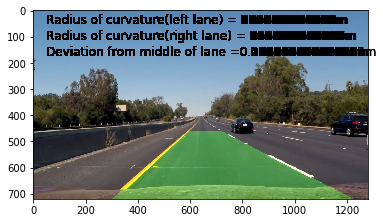

In [20]:
video_output = 'result.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(lane_video) 
white_clip.write_videofile(video_output, audio=False)